In [4]:
import numpy as np
import pandas as pd
import pickle as pl
import pylab as pyl
from sklearn.metrics.pairwise import euclidean_distances
from ptsa.data.filters import ButterworthFilter
from ptsa.data.filters import MorletWaveletFilter
from ptsa.data.filters import ResampleFilter
from ptsa.data.timeseries import TimeSeries

from cmlreaders import CMLReader

from scipy.io import loadmat
from scipy import stats
#import mne
from mne.viz import plot_alignment, snapshot_brain_montage
from ipywidgets import IntProgress

from PIL import Image, ImageDraw, ImageFont

import os

from tarjan import tarjan

from sklearn.metrics.pairwise import euclidean_distances

from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from tqdm import tqdm

import matplotlib.colors as colors
import matplotlib.cm as cmx
import nilearn.plotting as ni_plot
from matplotlib import pyplot as plt
import sys
#sys.path.append('/home1/anup.das/RAM_ECoG')
import RAM_helpers_New

import statsmodels.api as sm
from scipy import stats
from scipy import signal
from scipy.fft import fft, ifft
import scipy as sp
#from findpeaks import findpeaks

import warnings
from cmlreaders.warnings import MultiplePathsFoundWarning
from cmlreaders.warnings import MissingCoordinatesWarning
warnings.filterwarnings(action = 'ignore', category = MultiplePathsFoundWarning)
warnings.filterwarnings(action = 'ignore', category = MissingCoordinatesWarning)

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [5]:
# get TH1 subjects
subjs=RAM_helpers_New.get_subjs_and_montages('RAM_TH1')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)
subjs = subjs.drop([subjs.index[8], subjs.index[16], subjs.index[23], subjs.index[31], subjs.index[33], subjs.index[37], subjs.index[40], subjs.index[51], subjs.index[55], subjs.index[59], subjs.index[61], subjs.index[62], subjs.index[64]])
subjs = subjs.reset_index(drop=True)
subjs

,subject,montage
0,R1076D,0
1,R1124J,0
2,R1132C,0
3,R1133C,0
4,R1145J,0
5,R1147P,0
6,R1154D,0
7,R1155D,0
8,R1156D,0
9,R1157C,0


In [6]:
#Find subjects with only grids and strips electrodes
Count_Grids_Strips = np.empty(0)
for i in range(0,np.shape(subjs)[0],1):
    subject = subjs['subject'].iloc[i]
    montage = subjs['montage'].iloc[i]
    monopol_chans = RAM_helpers_New.load_elec_info(subject, montage, bipolar=False)
    monopol_chans_types = monopol_chans['type']
    monopol_chans_types_counts_grids = monopol_chans_types.str.count('G')
    monopol_chans_types_counts_strips = monopol_chans_types.str.count('S')
    monopol_chans_types_counts_grids_strips = sum(np.asarray(monopol_chans_types_counts_grids)) + sum(np.asarray(monopol_chans_types_counts_strips))
    Count_Grids_Strips = np.append(Count_Grids_Strips, np.array([monopol_chans_types_counts_grids_strips]), axis=0)
    del subject
    del montage
    del monopol_chans_types
    del monopol_chans_types_counts_grids
    del monopol_chans_types_counts_strips
    del monopol_chans_types_counts_grids_strips
    
subjs_grids_strips = subjs.iloc[np.nonzero(Count_Grids_Strips)]
subjs_grids_strips = subjs_grids_strips.reset_index(drop=True)
del subjs
subjs = subjs_grids_strips
subjs

,subject,montage
0,R1076D,0
1,R1147P,0
2,R1154D,0
3,R1155D,0
4,R1156D,0
5,R1167M,0
6,R1172E,0
7,R1184M,0
8,R1190P,0
9,R1194E,0


In [6]:
#Find minimum sampling frequency
Samp_Freq_All = np.empty(0)
for i in range(0,np.shape(subjs)[0],1):
    subject = subjs['subject'].iloc[i]
    montage = subjs['montage'].iloc[i]
    events = RAM_helpers_New.load_subj_events('RAM_TH1', subject, montage, as_df=True, remove_no_eeg=True)
    events_short = events.iloc[[0]]
    monopol_chans = RAM_helpers_New.load_elec_info(subject, montage, bipolar=False)
    eeg = RAM_helpers_New.load_eeg(events_short, rel_start_ms=0, rel_stop_ms=1600, buf_ms=1000, elec_scheme=monopol_chans, noise_freq=[58., 62.], resample_freq=None, pass_band=None, use_mirror_buf=False, demean=True, do_average_ref=True)
    Samp_Freq_All = np.append(Samp_Freq_All, np.array([float(eeg.samplerate)]), axis=0)
    del subject
    del montage
    del events
    del events_short
    del monopol_chans
    del eeg 
Samp_Freq_All
np.unique(Samp_Freq_All)
Samp_Freq = np.min(np.unique(Samp_Freq_All))
Samp_Freq_All

array([1000., 1000., 1000., 1600., 1000., 1000., 1000., 1000., 1000.,
       1000., 1000.,  500., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000., 1000., 1000.])

In [10]:
#Calculate power (new algorithm)
freqs = np.geomspace(3, 40, num=200)
i_subj = 1
subject = subjs['subject'].iloc[i_subj]
montage = subjs['montage'].iloc[i_subj]
events = RAM_helpers_New.load_subj_events('RAM_TH1', subject, montage, as_df=True, remove_no_eeg=True)
events_REC = events[events['type'] == 'REC']
events_REC = events_REC.reset_index(drop=True)
del events
events = events_REC

monopol_chans = RAM_helpers_New.load_elec_info(subject, montage, bipolar=False)
monopol_chans_grids_strips = monopol_chans[(monopol_chans['type'] == 'G') | (monopol_chans['type'] == 'S')]
monopol_chans_grids_strips = monopol_chans_grids_strips.reset_index(drop=True)
del monopol_chans
monopol_chans = monopol_chans_grids_strips

TAL_Coords = monopol_chans[['tal.x', 'tal.y', 'tal.z']]
xyz_All_TAL = np.asarray(TAL_Coords)
Dist_Mat = euclidean_distances(xyz_All_TAL, xyz_All_TAL)
np.fill_diagonal(Dist_Mat, 1)
for i_row in range(0,np.shape(Dist_Mat)[0],1):
    for j_col in range(0,np.shape(Dist_Mat)[1],1):
        Dist_Mat[i_row, j_col] = RAM_helpers_New.truncate(Dist_Mat[i_row, j_col], 3)
Zero_Indices = np.empty(0)
for i_row in range(0,np.shape(Dist_Mat)[0],1):
    Zero_Indices = np.append(Zero_Indices, np.where(Dist_Mat[i_row,:] == 0)[0], axis=0)
Zero_Indices = np.unique(Zero_Indices).astype(int)
monopol_chans = monopol_chans.drop(monopol_chans.index[np.unique(Zero_Indices).astype(int)])
monopol_chans = monopol_chans.reset_index(drop=True)

eeg_power = RAM_helpers_New.compute_power(events, freqs, wave_num = 5, rel_start_ms=0, rel_stop_ms=1500, 
                                                    buf_ms=1000, elec_scheme=monopol_chans, noise_freq=[58., 62.], 
                                                    resample_freq=Samp_Freq, mean_over_time=True, log_power=True, 
                                                    loop_over_chans=True, cluster_pool=None, use_mirror_buf=False, 
                                                    time_bins=None, do_average_ref=True)
print(eeg_power)

100%|██████████| 102/102 [01:17<00:00,  1.32it/s]

<xarray.TimeSeries (event: 73, frequency: 200, channel: 102)>
array([[[7.44122029, 6.85998061, 6.88726325, ..., 6.95868178,
         7.06033797, 6.65335413],
        [7.44974086, 6.81483119, 6.8963962 , ..., 6.95684878,
         7.05565772, 6.6653443 ],
        [7.45363433, 6.8264596 , 6.90075349, ..., 6.95068958,
         7.04758291, 6.67314107],
        ...,
        [5.06680667, 5.51896169, 5.35790456, ..., 5.53609255,
         5.61490499, 5.67766058],
        [5.05859956, 5.5059878 , 5.3443526 , ..., 5.52607972,
         5.60654   , 5.65787656],
        [5.05083392, 5.49168479, 5.33245718, ..., 5.52044061,
         5.59429462, 5.64160901]],

       [[7.44791628, 7.06095686, 6.98700508, ..., 7.03739336,
         6.67543877, 6.51913576],
        [7.40030147, 7.06026563, 6.95698285, ..., 7.00509629,
         6.65171376, 6.50064031],
        [7.35355358, 7.05554036, 6.92484022, ..., 6.97114123,
         6.62692282, 6.480328  ],
...
        [4.86445358, 5.40493918, 5.28513111, ..., 5.043

In [96]:
#Calculate power (new algorithm)
freqs = np.geomspace(3, 40, num=200)
#i_subj = 2
for i_subj in range(1,4,1):

    subject = subjs['subject'].iloc[i_subj]
    montage = subjs['montage'].iloc[i_subj]
    events = RAM_helpers_New.load_subj_events('RAM_TH1', subject, montage, as_df=True, remove_no_eeg=True)
    events_REC = events[events['type'] == 'REC']
    events_REC = events_REC.reset_index(drop=True)
    del events
    events = events_REC

    monopol_chans = RAM_helpers_New.load_elec_info(subject, montage, bipolar=False)
    monopol_chans_grids_strips = monopol_chans[(monopol_chans['type'] == 'G') | (monopol_chans['type'] == 'S')]
    monopol_chans_grids_strips = monopol_chans_grids_strips.reset_index(drop=True)
    del monopol_chans
    monopol_chans = monopol_chans_grids_strips

    TAL_Coords = monopol_chans[['tal.x', 'tal.y', 'tal.z']]
    xyz_All_TAL = np.asarray(TAL_Coords)
    Dist_Mat = euclidean_distances(xyz_All_TAL, xyz_All_TAL)
    np.fill_diagonal(Dist_Mat, 1)
    for i_row in range(0,np.shape(Dist_Mat)[0],1):
        for j_col in range(0,np.shape(Dist_Mat)[1],1):
            Dist_Mat[i_row, j_col] = RAM_helpers_New.truncate(Dist_Mat[i_row, j_col], 3)
    Zero_Indices = np.empty(0)
    for i_row in range(0,np.shape(Dist_Mat)[0],1):
        Zero_Indices = np.append(Zero_Indices, np.where(Dist_Mat[i_row,:] == 0)[0], axis=0)
    Zero_Indices = np.unique(Zero_Indices).astype(int)
    monopol_chans = monopol_chans.drop(monopol_chans.index[np.unique(Zero_Indices).astype(int)])
    monopol_chans = monopol_chans.reset_index(drop=True)

    eeg_power = RAM_helpers_New.compute_power(events, freqs, wave_num = 5, rel_start_ms=0, rel_stop_ms=1500, 
                                                    buf_ms=1000, elec_scheme=monopol_chans, noise_freq=[58., 62.], 
                                                    resample_freq=Samp_Freq, mean_over_time=True, log_power=True, 
                                                    loop_over_chans=True, cluster_pool=None, use_mirror_buf=False, 
                                                    time_bins=None, do_average_ref=True)

100%|██████████| 84/84 [02:11<00:00,  1.56s/it]


In [154]:
#Find peaks in each electrode (single peak)
eeg_power_mean = np.mean(eeg_power, axis = 0)
#print(eeg_power_mean)
freqs = np.geomspace(3, 40, num=200)
#print(freqs[163])
#Return numbers spaced evenly on a log scale (a geometric progression).
Freqs_Peak_All = np.empty(0)

for i_Electrode in range(0,np.shape(eeg_power_mean)[1],1):

    x = sm.tools.tools.add_constant(np.log10(np.transpose(freqs)))
    model_res = sm.RLM(np.asarray(eeg_power_mean[:,i_Electrode]), x).fit()
    resid_zscored = stats.zscore(model_res.resid)

    Index_Peaks = sp.signal.find_peaks(resid_zscored)[0]
    Values_Peaks = resid_zscored[Index_Peaks]
    Index_Peaks_Th = np.argwhere(Values_Peaks > 1)
#np.argwhere, Find the indices of array elements that are non-zero, grouped by element.
    if Index_Peaks_Th.size > 0:

        if (np.squeeze(Index_Peaks_Th)).size == 1:

            Index_Peaks_All_Th = np.array([Index_Peaks[np.squeeze(Index_Peaks_Th)]])
            Values_Peaks_All_Th = np.array([Values_Peaks[np.squeeze(Index_Peaks_Th)]])
            Index_Peaks_Max_Th = Index_Peaks_All_Th[np.array(np.argmax(Values_Peaks_All_Th))]
            #print(np.array([Index_Peaks_Max_Th]))
            Freqs_Peak = freqs[np.array([Index_Peaks_Max_Th])]
            Freqs_Peak_All = np.append(Freqs_Peak_All, Freqs_Peak, axis=0)

        else:

            Index_Peaks[np.squeeze(Index_Peaks_Th)]
            Index_Peaks_All_Th = np.array([Index_Peaks[np.squeeze(Index_Peaks_Th)]])
            Values_Peaks_All_Th = np.array([Values_Peaks[np.squeeze(Index_Peaks_Th)]])
            Index_Peaks_All_Th = np.squeeze(Index_Peaks_All_Th)
            Index_Peaks_Max_Th = Index_Peaks_All_Th[np.array(np.argmax(Values_Peaks_All_Th))]
            Freqs_Peak = freqs[np.array([Index_Peaks_Max_Th])]  
            Freqs_Peak_All = np.append(Freqs_Peak_All, Freqs_Peak, axis=0)
            
    else:
        
        Freqs_Peak_All = np.append(Freqs_Peak_All, np.array([0]), axis=0)
    
    del x
    del model_res

#print(Freqs_Peak)
print(Freqs_Peak_All)
#print(len(Freqs_Peak_All))
print(Freqs_Peak_All[2] )

<xarray.TimeSeries (frequency: 200, channel: 64)>
array([[6.75400853, 6.69414738, 6.8009661 , ..., 7.00816015, 7.18241925,
        6.98754338],
       [6.7486673 , 6.69291599, 6.79627321, ..., 7.00133574, 7.17785133,
        6.98394198],
       [6.74352405, 6.69152023, 6.79150402, ..., 6.99374939, 7.17312889,
        6.98005174],
       ...,
       [5.07285195, 4.75345326, 5.05633953, ..., 4.98291598, 5.23644861,
        5.42308336],
       [5.05832075, 4.73817912, 5.04094316, ..., 4.96769625, 5.22140568,
        5.40833384],
       [5.04406162, 4.72301848, 5.02567166, ..., 4.95261449, 5.20654828,
        5.39404429]])
Coordinates:
  * channel     (channel) <U6 'LTCG1' 'LTCG2' 'LTCG3' ... 'LSTG11' 'LSTG12'
    samplerate  float64 500.0
  * frequency   (frequency) float64 3.0 3.039 3.079 3.119 ... 38.97 39.48 40.0
[11.61526001 12.07779938 12.23603668 15.06912744 14.68189753 11.02597751
 11.61526001 18.08129469 11.76743735 11.92160843 12.55875786 14.1196299
 13.57889524 14.4920302  11.61

(200, 84)


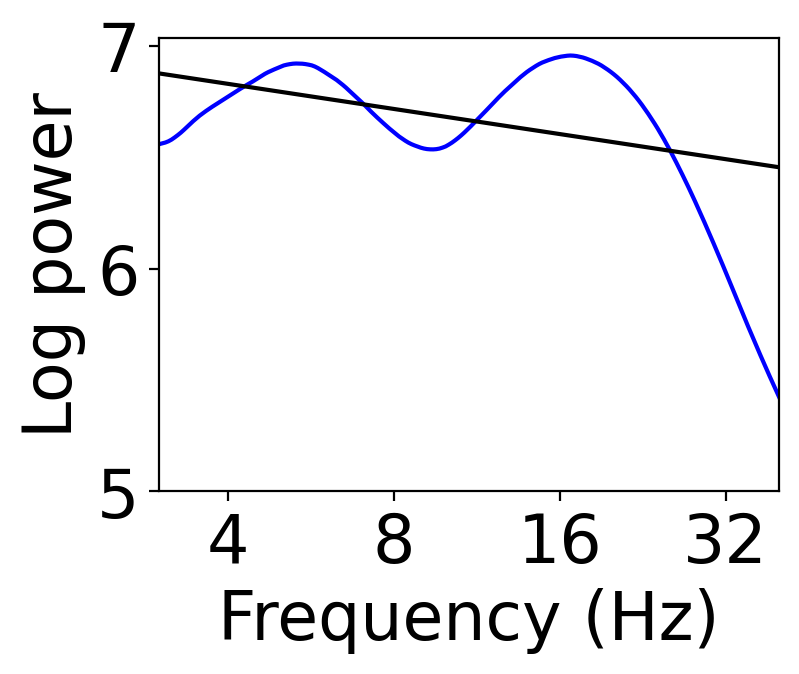

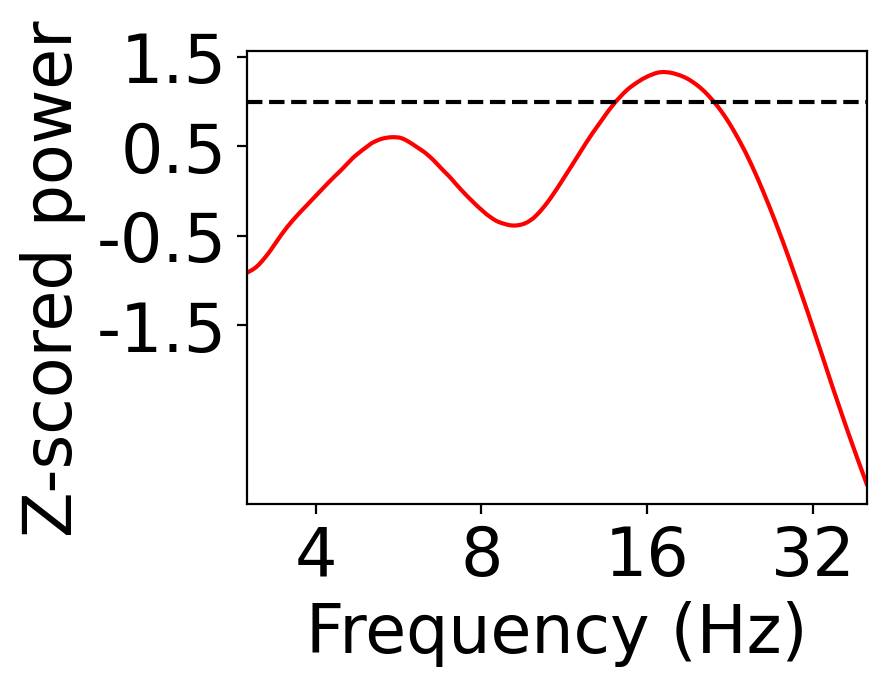

In [106]:
freqs = np.geomspace(3, 40, num=200)

#print(np.shape(eeg_power))
eeg_power_mean = np.mean(eeg_power, axis = 0)
print(np.shape(eeg_power_mean))

#i_Electrode = 20
i_Electrode = 19

x = sm.tools.tools.add_constant(np.log10(np.transpose(freqs)))
model_res = sm.RLM(np.asarray(eeg_power_mean[:,i_Electrode]), x).fit()
fitted_line = model_res.params[1]*np.log10(np.transpose(freqs)) + model_res.params[0]

#plt.figure(0)
#plt.semilogx(freqs, eeg_power_mean[:,i_Electrode])
#plt.xticks([])
#plt.xlabel('Frequency (Hz)')
#plt.ylabel('Log power')
#plt.xlim(2, 32)
#plt.savefig('LP.png', dpi=300, bbox_inches='tight')

plt.figure(figsize=(4,3), dpi= 200)
#plt.figure(0)
plt.semilogx(freqs, eeg_power_mean[:,i_Electrode],'b')
plt.semilogx(freqs, fitted_line, 'k-')
plt.xticks([])
plt.xlabel('Frequency (Hz)', fontsize=24)
plt.ylabel('Log power', fontsize=24)
plt.xticks([4, 8, 16, 32], ['4', '8', '16', '32'], fontsize=24)
plt.yticks([5, 6, 7], ['5', '6', '7'], fontsize=24)
plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xlim(3, 40)
#plt.savefig('LP1.png', dpi=300, bbox_inches='tight')

"""plt.figure(1)
plt.semilogx(freqs, model_res.resid,'r-')
plt.xticks([])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Log normalized power')
plt.xticks([4, 8, 16, 32], ['4', '8', '16', '32'])
plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xlim(2, 32)"""

plt.figure(figsize=(4,3), dpi= 200)
resid_zscored = stats.zscore(model_res.resid)
#plt.figure(2)
plt.semilogx(freqs, resid_zscored,'r-')
plt.xticks([])
plt.xlabel('Frequency (Hz)', fontsize=24)
plt.ylabel('Z-scored power', fontsize=24)
plt.xticks([2, 4, 8, 16, 32], ['2', '4', '8', '16', '32'], fontsize=24)
plt.yticks([-1.5, -0.5, 0.5, 1.5], ['-1.5', '-0.5', '0.5', '1.5'], fontsize=24)
plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xlim(3, 40)
plt.plot([3, 40], [1, 1], 'k--')
#plt.savefig('LNZP1.png', dpi=300, bbox_inches='tight')

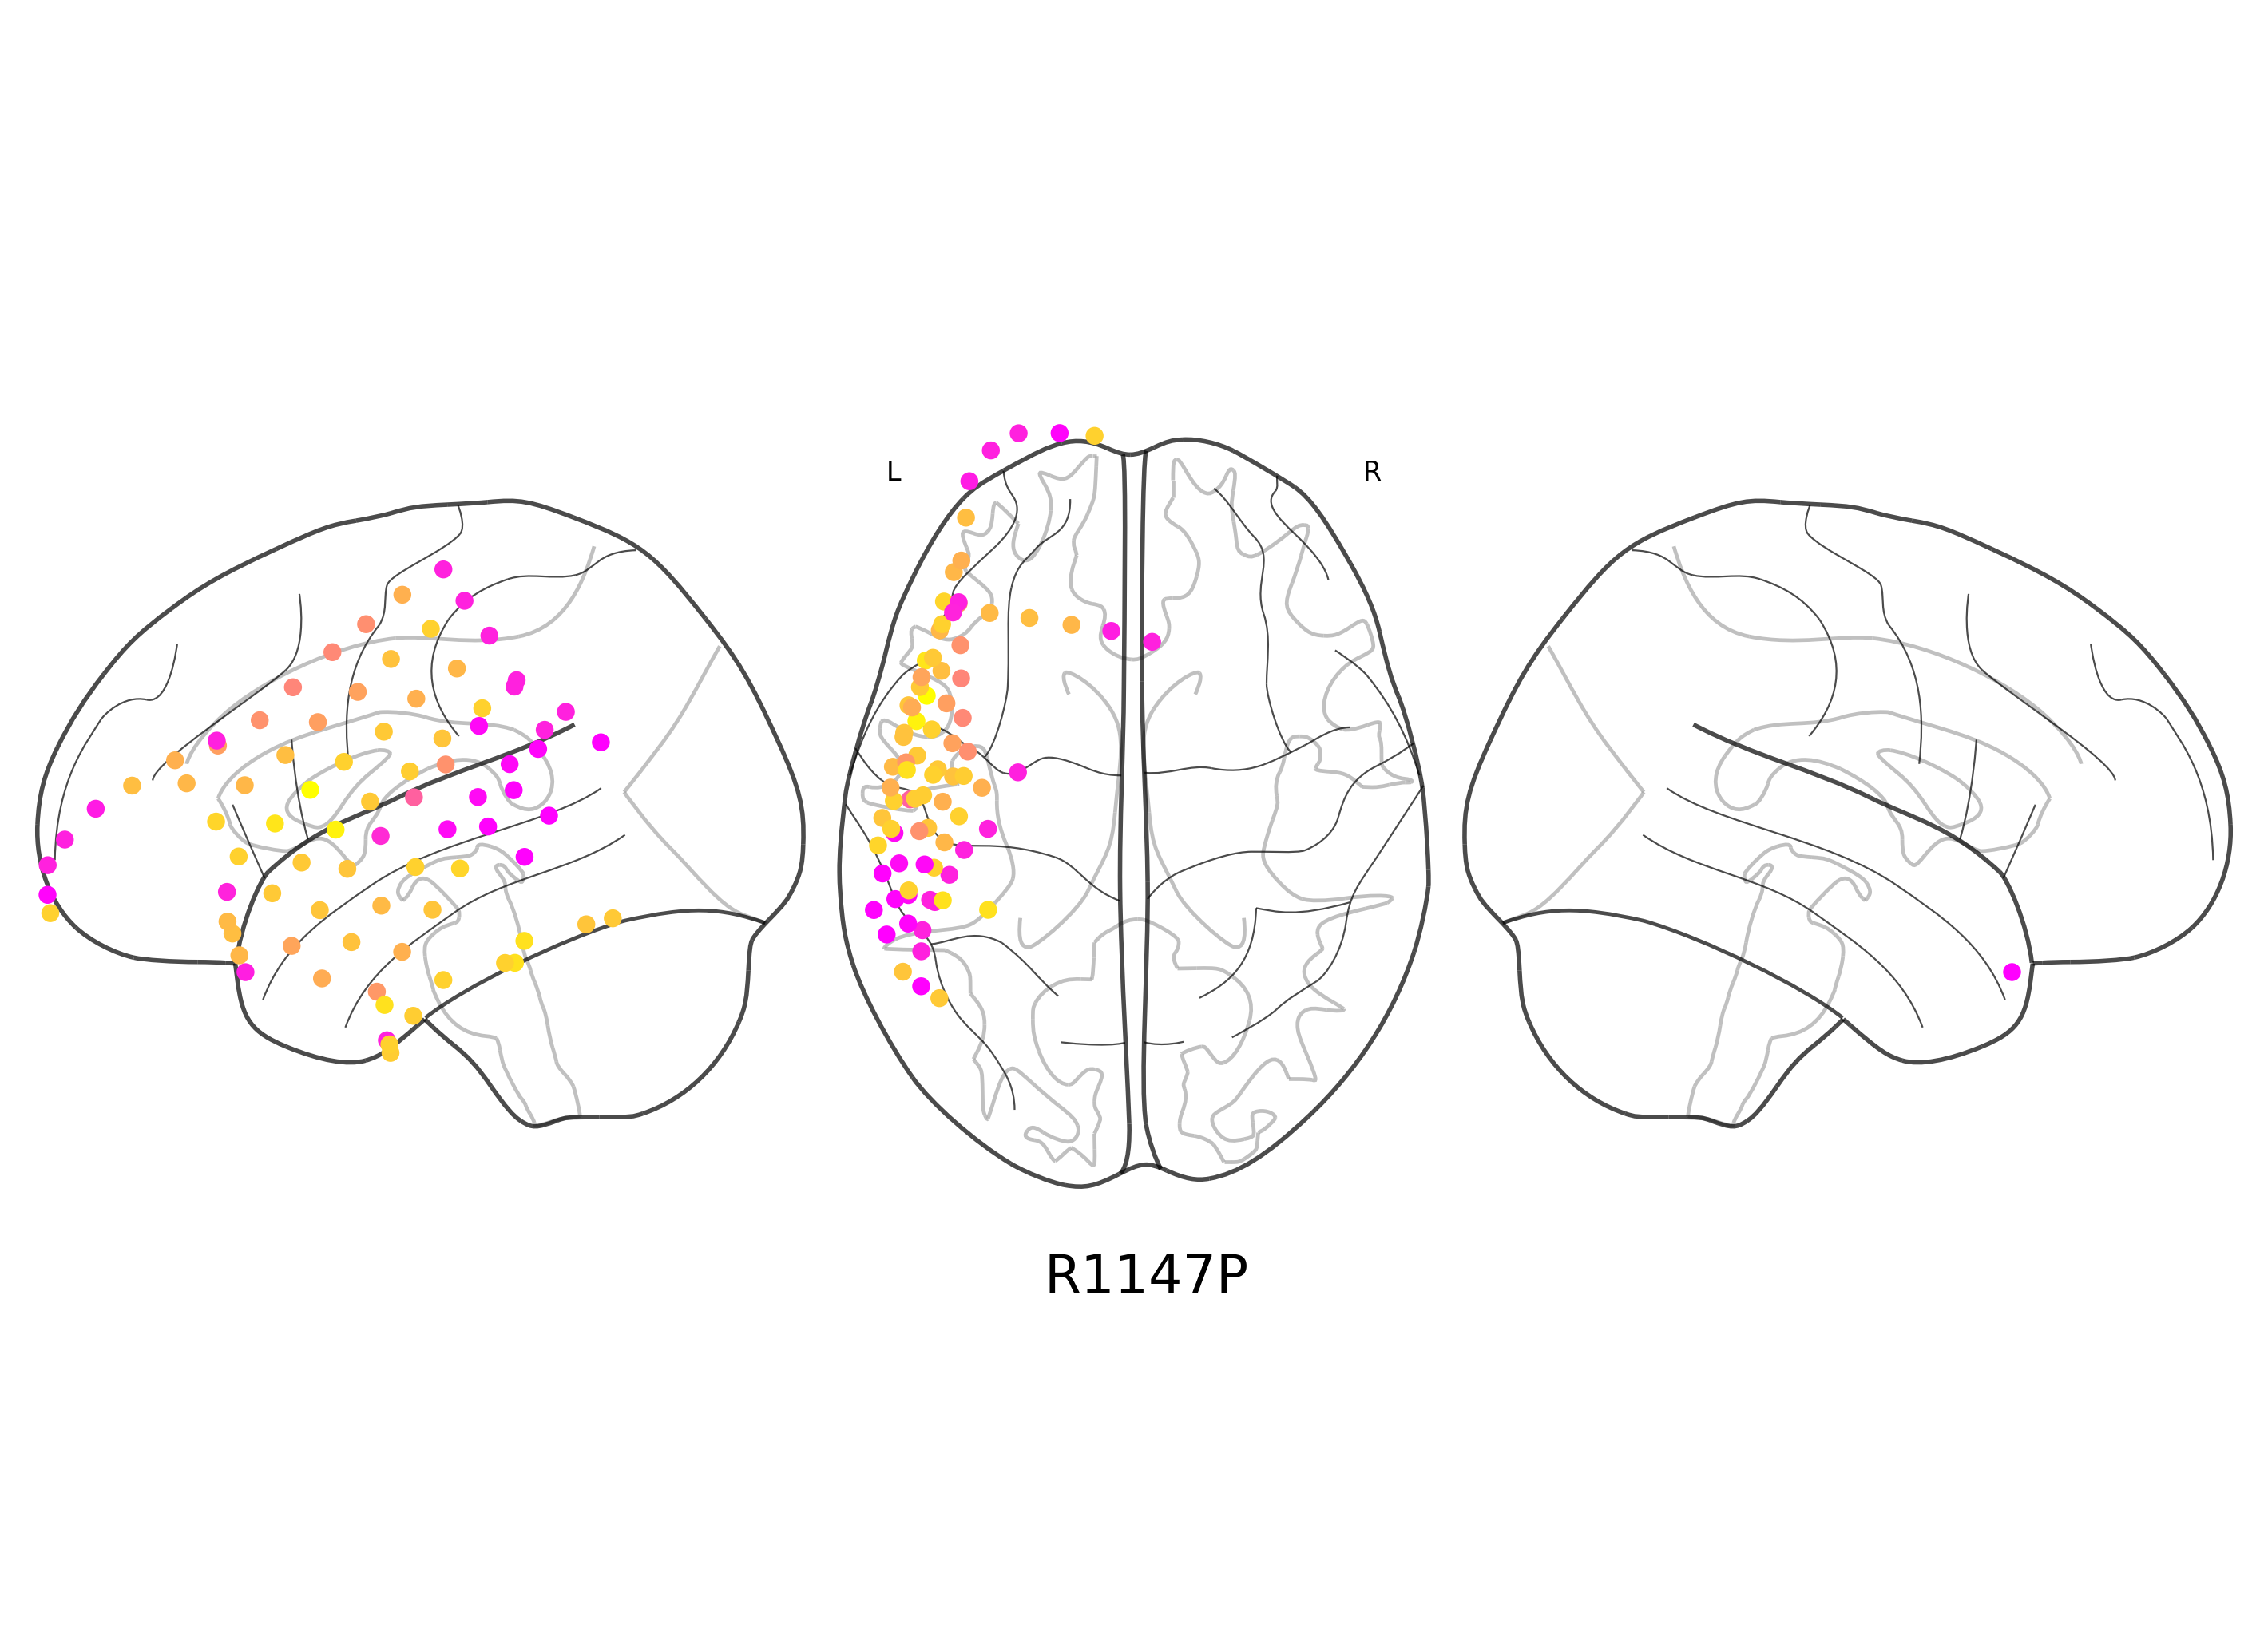

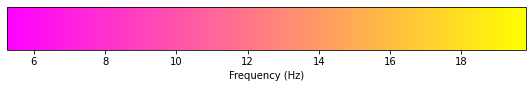

In [146]:
#Find peak frequencies and plot them in a brain plot
freqs = np.geomspace(3, 40, num=200)
#Results_Dir = '/home1/anup.das/Results/Brain_Plots_Frequency_Grids_Strips/Retrieval/'
for i_subj in range(1,2,1):
    
    subject = subjs['subject'].iloc[i_subj]
    montage = subjs['montage'].iloc[i_subj]
    
    monopol_chans = RAM_helpers_New.load_elec_info(subject, montage, bipolar=False)
    monopol_chans_grids_strips = monopol_chans[(monopol_chans['type'] == 'G') | (monopol_chans['type'] == 'S')]
    monopol_chans_grids_strips = monopol_chans_grids_strips.reset_index(drop=True)
    del monopol_chans
    monopol_chans = monopol_chans_grids_strips
    
    TAL_Coords = monopol_chans[['tal.x', 'tal.y', 'tal.z']]
    xyz_All_TAL = np.asarray(TAL_Coords)
    Dist_Mat = euclidean_distances(xyz_All_TAL, xyz_All_TAL)
    np.fill_diagonal(Dist_Mat, 1)
    Zero_Indices = np.empty(0)
    for i_row in range(0,np.shape(Dist_Mat)[0],1):
        Zero_Indices = np.append(Zero_Indices, np.where(Dist_Mat[i_row,:] == 0)[0], axis=0)
    Zero_Indices = np.unique(Zero_Indices).astype(int)
    monopol_chans = monopol_chans.drop(monopol_chans.index[np.unique(Zero_Indices).astype(int)])
    monopol_chans = monopol_chans.reset_index(drop=True)
    del TAL_Coords
    del xyz_All_TAL
    

    eeg_power_mean = np.mean(eeg_power, axis = 0)

    Freqs_Peak_All = np.empty(0)

    #np.shape(eeg_power_mean)[1]
    for i_Electrode in range(0,np.shape(eeg_power_mean)[1],1):

        x = sm.tools.tools.add_constant(np.log10(np.transpose(freqs)))
        model_res = sm.RLM(np.asarray(eeg_power_mean[:,i_Electrode]), x).fit()
        resid_zscored = stats.zscore(model_res.resid)

        Index_Peaks = sp.signal.find_peaks(resid_zscored)[0]
        Values_Peaks = resid_zscored[Index_Peaks]
        Index_Peaks_Th = np.argwhere(Values_Peaks > 1)

        if Index_Peaks_Th.size > 0:

            if (np.squeeze(Index_Peaks_Th)).size == 1:

                Index_Peaks_All_Th = np.array([Index_Peaks[np.squeeze(Index_Peaks_Th)]])
                Values_Peaks_All_Th = np.array([Values_Peaks[np.squeeze(Index_Peaks_Th)]])
                Index_Peaks_Max_Th = Index_Peaks_All_Th[np.array(np.argmax(Values_Peaks_All_Th))]
                Freqs_Peak = freqs[np.array([Index_Peaks_Max_Th])]
                Freqs_Peak_All = np.append(Freqs_Peak_All, Freqs_Peak, axis=0)

            else:

                Index_Peaks[np.squeeze(Index_Peaks_Th)]
                Index_Peaks_All_Th = np.array([Index_Peaks[np.squeeze(Index_Peaks_Th)]])
                Values_Peaks_All_Th = np.array([Values_Peaks[np.squeeze(Index_Peaks_Th)]])
                Index_Peaks_All_Th = np.squeeze(Index_Peaks_All_Th)
                Index_Peaks_Max_Th = Index_Peaks_All_Th[np.array(np.argmax(Values_Peaks_All_Th))]
                Freqs_Peak = freqs[np.array([Index_Peaks_Max_Th])]  
                Freqs_Peak_All = np.append(Freqs_Peak_All, Freqs_Peak, axis=0)

        else:

            Freqs_Peak_All = np.append(Freqs_Peak_All, np.array([0]), axis=0)

        del x
        del model_res
        
    #if Freqs_Peak_All > 12:
       # print("i")
    """if 'mni.x' in monopol_chans:

        MNI_Coords = monopol_chans[['mni.x', 'mni.y', 'mni.z']]
        xyz_All = np.asarray(MNI_Coords)

    else:

        TAL_Coords = monopol_chans[['tal.x', 'tal.y', 'tal.z']]
        xyz_All_TAL = np.asarray(TAL_Coords)
        xyz_All = RAM_helpers_New.tal2mni(xyz_All_TAL)"""

    TAL_Coords = monopol_chans[['tal.x', 'tal.y', 'tal.z']]
    xyz_All_TAL = np.asarray(TAL_Coords)
    xyz_All = RAM_helpers_New.tal2mni(xyz_All_TAL)
    
    fig = plt.figure(figsize=(14,10), dpi= 200)
    ColorMap = plt.get_cmap('spring') 
    for i in range (1,len(Freqs_Peak_All)):
        if Freqs_Peak_All(i) > 12:
            ni_plot.plot_connectome(np.eye(xyz.shape[0]), xyz,
                                            node_kwargs={'alpha': 1, 'edgecolors': None, 'cmap': ColorMap},
                                            node_size=50, node_color = values, display_mode='lzr', figure=fig)
    #for i in range (1,len(Freqs_Peak_All),1):
        # if Freqs_Peak_All(i) >12:
        #print(Freqs_Peak_All(3))  
    if np.where(Freqs_Peak_All == 0)[0].size > 0:

        if np.where(Freqs_Peak_All == 0)[0].size == 1:
            xyz_NoColor = xyz_All[np.where(Freqs_Peak_All == 0)[0],:]
        else:
            xyz_NoColor = np.squeeze(xyz_All[np.where(Freqs_Peak_All == 0)[0],:])

        ni_plot.plot_connectome(np.eye(xyz_NoColor.shape[0]), xyz_NoColor,
                                            node_kwargs={'alpha': 1, 'edgecolors': None},
                                            node_size=50, node_color = 'k', display_mode='lzr', figure=fig)

    plt.figtext(0.46, 0.2, subject, fontsize = 24)
    plt.savefig('Brain.png', dpi=300, bbox_inches='tight')

    #a = np.array([[np.min(values), np.max(values)]])
    a = np.array([[np.min(Freqs_Peak_All), np.max(Freqs_Peak_All)]])
    pyl.figure(figsize=(9, 1.5))
    img = pyl.imshow(a, cmap="spring")
    pyl.gca().set_visible(False)
    cax = pyl.axes([0.1, 0.2, 0.8, 0.4])
    pyl.colorbar(orientation="horizontal", cax=cax, label = 'Frequency (Hz)')

    plt.savefig('Colorbar.png', dpi=300, bbox_inches='tight')

    im1 = Image.open('Brain.png')
    im2 = Image.open('Colorbar.png')
    Combined = im1.copy()
    Combined.paste(im2, (950, 350))
    #Combined.save(Results_Dir + 'Brain_Plot_Frequency_' + str(i_subj) + '.png', quality=300)

    os.remove('Brain.png') 
    os.remove('Colorbar.png') 
    
    del subject
    del montage
    del monopol_chans
    del monopol_chans_grids_strips
    del TAL_Coords

In [38]:
import pickle
f = open('somefile', 'wb')
 # Some Python object
#Calculate power (new algorithm)
freqs = np.geomspace(3, 40, num=200)
for i_subj in range(1,20,1):
    xyz=[]
    n=[]
    m=[]
    high_freq=[]
#for i_subj in range(0,np.shape(subjs)[0],1):    
    subject = subjs['subject'].iloc[i_subj]
    montage = subjs['montage'].iloc[i_subj]
    events = RAM_helpers_New.load_subj_events('RAM_TH1', subject, montage, as_df=True, remove_no_eeg=True)
    events_REC = events[events['type'] == 'REC']
    events_REC = events_REC.reset_index(drop=True)
    del events
    events = events_REC

    monopol_chans = RAM_helpers_New.load_elec_info(subject, montage, bipolar=False)
    monopol_chans_grids_strips = monopol_chans[(monopol_chans['type'] == 'G') | (monopol_chans['type'] == 'S')]
    monopol_chans_grids_strips = monopol_chans_grids_strips.reset_index(drop=True)
    del monopol_chans
    monopol_chans = monopol_chans_grids_strips
    if 'mni.x' in monopol_chans :
        TAL_Coords=monopol_chans[['tal.x', 'tal.y', 'tal.z']]
    elif 'tal.x' in monopol_chans:
        TAL_Coords = monopol_chans[['tal.x', 'tal.y', 'tal.z']]
    #TAL_Coords = monopol_chans[['tal.x', 'tal.y', 'tal.z']]
    xyz_All_TAL = np.asarray(TAL_Coords)
    Dist_Mat = euclidean_distances(xyz_All_TAL, xyz_All_TAL)
    np.fill_diagonal(Dist_Mat, 1)
    for i_row in range(0,np.shape(Dist_Mat)[0],1):
        for j_col in range(0,np.shape(Dist_Mat)[1],1):
            Dist_Mat[i_row, j_col] = RAM_helpers_New.truncate(Dist_Mat[i_row, j_col], 3)
    Zero_Indices = np.empty(0)
    for i_row in range(0,np.shape(Dist_Mat)[0],1):
        Zero_Indices = np.append(Zero_Indices, np.where(Dist_Mat[i_row,:] == 0)[0], axis=0)
    Zero_Indices = np.unique(Zero_Indices).astype(int)
    monopol_chans = monopol_chans.drop(monopol_chans.index[np.unique(Zero_Indices).astype(int)])
    monopol_chans = monopol_chans.reset_index(drop=True)

    eeg_power = RAM_helpers_New.compute_power(events, freqs, wave_num = 5, rel_start_ms=0, rel_stop_ms=1500, 
                                                    buf_ms=1000, elec_scheme=monopol_chans, noise_freq=[58., 62.], 
                                                    resample_freq=Samp_Freq, mean_over_time=True, log_power=True, 
                                                    loop_over_chans=True, cluster_pool=None, use_mirror_buf=False, 
                                                    time_bins=None, do_average_ref=True)
    eeg_power_mean = np.mean(eeg_power, axis = 0)

    
    pickle.dump(eeg_power_mean, f)



100%|██████████| 102/102 [01:06<00:00,  1.54it/s]


<xarray.TimeSeries (frequency: 200, channel: 102)>
array([[6.74407336, 6.99207634, 6.7140124 , ..., 6.74729419, 6.70506518,
        6.55543118],
       [6.73706375, 6.98896571, 6.71933202, ..., 6.74261841, 6.70268586,
        6.5496119 ],
       [6.73016459, 6.98743   , 6.72419704, ..., 6.735793  , 6.69980552,
        6.54689736],
       ...,
       [4.903962  , 5.42219314, 5.28620302, ..., 5.25631282, 5.37801809,
        5.47861008],
       [4.89511742, 5.41086426, 5.27496048, ..., 5.2487276 , 5.36679918,
        5.46342104],
       [4.88654933, 5.40018825, 5.2646169 , ..., 5.24049467, 5.35552733,
        5.44821024]])
Coordinates:
  * channel     (channel) <U5 'LGR1' 'LGR2' 'LGR3' ... 'LSP6' 'LSP7' 'LSP8'
    samplerate  float64 500.0
  * frequency   (frequency) float64 3.0 3.039 3.079 3.119 ... 38.97 39.48 40.0


100%|██████████| 64/64 [01:56<00:00,  1.82s/it]


<xarray.TimeSeries (frequency: 200, channel: 64)>
array([[6.75400853, 6.69414738, 6.8009661 , ..., 7.00816015, 7.18241925,
        6.98754338],
       [6.7486673 , 6.69291599, 6.79627321, ..., 7.00133574, 7.17785133,
        6.98394198],
       [6.74352405, 6.69152023, 6.79150402, ..., 6.99374939, 7.17312889,
        6.98005174],
       ...,
       [5.07285195, 4.75345326, 5.05633953, ..., 4.98291598, 5.23644861,
        5.42308336],
       [5.05832075, 4.73817912, 5.04094316, ..., 4.96769625, 5.22140568,
        5.40833384],
       [5.04406162, 4.72301848, 5.02567166, ..., 4.95261449, 5.20654828,
        5.39404429]])
Coordinates:
  * channel     (channel) <U6 'LTCG1' 'LTCG2' 'LTCG3' ... 'LSTG11' 'LSTG12'
    samplerate  float64 500.0
  * frequency   (frequency) float64 3.0 3.039 3.079 3.119 ... 38.97 39.48 40.0


100%|██████████| 84/84 [02:06<00:00,  1.51s/it]


<xarray.TimeSeries (frequency: 200, channel: 84)>
array([[6.19223195, 6.52617052, 6.77663606, ..., 6.13178973, 6.10438048,
        6.16243621],
       [6.19533492, 6.53063574, 6.7816961 , ..., 6.13589106, 6.10772104,
        6.16717141],
       [6.19917683, 6.53558854, 6.78695201, ..., 6.1407707 , 6.11284242,
        6.17231379],
       ...,
       [4.5528189 , 4.85516945, 5.30382233, ..., 4.7971196 , 4.65633088,
        4.55973778],
       [4.53118802, 4.83189   , 5.28383781, ..., 4.76749239, 4.6290932 ,
        4.53316386],
       [4.50973284, 4.80868379, 5.26401585, ..., 4.73783629, 4.60212988,
        4.50677589]])
Coordinates:
  * channel     (channel) <U6 'LFG1' 'LFG2' 'LFG3' ... 'RLFS6' 'RLFS7' 'RLFS8'
    samplerate  float64 500.0
  * frequency   (frequency) float64 3.0 3.039 3.079 3.119 ... 38.97 39.48 40.0


100%|██████████| 104/104 [01:24<00:00,  1.22it/s]


<xarray.TimeSeries (frequency: 200, channel: 104)>
array([[6.67921388, 6.75026041, 6.68938292, ..., 6.82156327, 6.53755617,
        6.57993585],
       [6.67503125, 6.74181403, 6.68217865, ..., 6.81926875, 6.53175087,
        6.5725852 ],
       [6.67008944, 6.73305594, 6.67498619, ..., 6.81790986, 6.52611014,
        6.56391369],
       ...,
       [5.55743819, 5.0872608 , 5.01144273, ..., 5.36255855, 4.95345489,
        5.07599226],
       [5.55219533, 5.08202788, 5.00536075, ..., 5.35126307, 4.94653458,
        5.06802294],
       [5.54557638, 5.07500033, 4.99729425, ..., 5.33883955, 4.93789552,
        5.0585571 ]])
Coordinates:
  * channel     (channel) <U6 'RFG1' 'RFG2' 'RFG3' ... 'LPFS5' 'LPFS7' 'LPFS8'
    samplerate  float64 500.0
  * frequency   (frequency) float64 3.0 3.039 3.079 3.119 ... 38.97 39.48 40.0


100%|██████████| 68/68 [01:19<00:00,  1.16s/it]


<xarray.TimeSeries (frequency: 200, channel: 68)>
array([[7.68699969, 7.38079656, 7.4345832 , ..., 7.11944833, 7.20420532,
        7.25501837],
       [7.68938   , 7.37998531, 7.43416918, ..., 7.11678759, 7.19953452,
        7.25222875],
       [7.69066653, 7.37958954, 7.43356415, ..., 7.11595673, 7.1942956 ,
        7.24885669],
       ...,
       [5.97661176, 5.68963682, 5.61911316, ..., 5.51784946, 5.902581  ,
        5.57571791],
       [5.96715218, 5.67939148, 5.6062587 , ..., 5.50543055, 5.89843066,
        5.5659701 ],
       [5.95797928, 5.66863754, 5.593031  , ..., 5.49293656, 5.89225317,
        5.55627856]])
Coordinates:
  * channel     (channel) <U5 'LAI1' 'LAI2' 'LAI3' 'LAI4' ... 'LP6' 'LP7' 'LP8'
    samplerate  float64 500.0
  * frequency   (frequency) float64 3.0 3.039 3.079 3.119 ... 38.97 39.48 40.0


100%|██████████| 24/24 [00:18<00:00,  1.26it/s]


<xarray.TimeSeries (frequency: 200, channel: 24)>
array([[7.71978181, 8.39175888, 7.54176526, ..., 7.49794912, 7.26064802,
        6.97685788],
       [7.71328512, 8.37076623, 7.52882484, ..., 7.4857897 , 7.24135719,
        6.96144891],
       [7.70751852, 8.35099453, 7.51911106, ..., 7.47404625, 7.22130626,
        6.94770565],
       ...,
       [4.86746327, 5.22094193, 5.02170671, ..., 5.11969549, 4.5780212 ,
        4.33033471],
       [4.85332456, 5.20818212, 5.0087028 , ..., 5.10845908, 4.56674559,
        4.31877416],
       [4.8393573 , 5.19551235, 4.99538683, ..., 5.09753056, 4.55574926,
        4.30726477]])
Coordinates:
  * channel     (channel) <U7 'RTS1' 'RTS2' 'RTS3' ... 'RTPOLS5' 'RTPOLS6'
    samplerate  float64 500.0
  * frequency   (frequency) float64 3.0 3.039 3.079 3.119 ... 38.97 39.48 40.0


100%|██████████| 48/48 [00:27<00:00,  1.75it/s]


<xarray.TimeSeries (frequency: 200, channel: 48)>
array([[6.93115932, 6.99155784, 6.98777116, ..., 8.09537351, 7.58479554,
        7.63432935],
       [6.92643496, 6.99061531, 6.99220279, ..., 8.09927744, 7.59096958,
        7.6377884 ],
       [6.92282586, 6.9912391 , 6.99709384, ..., 8.10141351, 7.59638476,
        7.63925337],
       ...,
       [5.68560565, 5.71333135, 4.91426593, ..., 6.00447741, 5.75982779,
        5.42431022],
       [5.66456273, 5.69737827, 4.89468684, ..., 5.99401824, 5.74876496,
        5.41078709],
       [5.6427417 , 5.68068356, 4.87556071, ..., 5.984555  , 5.73767324,
        5.3976884 ]])
Coordinates:
  * channel     (channel) <U5 'RTG1' 'RTG2' 'RTG3' ... 'RIPS2' 'RIPS3' 'RIPS4'
    samplerate  float64 500.0
  * frequency   (frequency) float64 3.0 3.039 3.079 3.119 ... 38.97 39.48 40.0


100%|██████████| 110/110 [02:02<00:00,  1.11s/it]


<xarray.TimeSeries (frequency: 200, channel: 110)>
array([[7.23268935, 7.14914447, 7.07084257, ..., 7.40392091, 7.20903034,
        7.11107223],
       [7.22838385, 7.14614576, 7.0774925 , ..., 7.39661777, 7.20750723,
        7.10920067],
       [7.22357461, 7.14289716, 7.0834208 , ..., 7.39031644, 7.20653494,
        7.10558056],
       ...,
       [5.42287755, 5.38356671, 5.68288844, ..., 5.36888531, 5.33502058,
        5.42122713],
       [5.40535896, 5.36748841, 5.66756323, ..., 5.35681634, 5.32105538,
        5.40945893],
       [5.38745246, 5.35130766, 5.65226391, ..., 5.34443716, 5.30672553,
        5.39734201]])
Coordinates:
  * channel     (channel) <U4 'LG1' 'LG2' 'LG3' 'LG4' ... 'RPT2' 'RPT3' 'RPT4'
    samplerate  float64 500.0
  * frequency   (frequency) float64 3.0 3.039 3.079 3.119 ... 38.97 39.48 40.0


100%|██████████| 42/42 [00:30<00:00,  1.37it/s]


<xarray.TimeSeries (frequency: 200, channel: 42)>
array([[7.0500874 , 7.24627951, 7.54421956, ..., 6.07494147, 6.10684877,
        6.06577361],
       [7.04015845, 7.23835486, 7.53993412, ..., 6.06393179, 6.1011927 ,
        6.05483455],
       [7.02960542, 7.22813138, 7.53460549, ..., 6.05190031, 6.09502957,
        6.04444456],
       ...,
       [5.68530209, 5.82977778, 5.88283368, ..., 5.0849621 , 5.08853989,
        5.09693171],
       [5.67998461, 5.8240785 , 5.87542587, ..., 5.0835967 , 5.08634367,
        5.09597146],
       [5.67273367, 5.81645687, 5.86677547, ..., 5.08003783, 5.08184707,
        5.09255324]])
Coordinates:
  * channel     (channel) <U5 '17LS1' '17LS3' '17LS5' ... '33LS5' '33LS7'
    samplerate  float64 500.0
  * frequency   (frequency) float64 3.0 3.039 3.079 3.119 ... 38.97 39.48 40.0


100%|██████████| 44/44 [01:33<00:00,  2.12s/it]


<xarray.TimeSeries (frequency: 200, channel: 44)>
array([[6.7311199 , 6.85311731, 6.85573863, ..., 7.13903335, 6.48886832,
        6.18032705],
       [6.72885642, 6.8515737 , 6.85649722, ..., 7.13356529, 6.48770402,
        6.17555554],
       [6.72617292, 6.85119657, 6.85777181, ..., 7.12814547, 6.48587275,
        6.17061849],
       ...,
       [5.50706645, 5.46439543, 5.49292559, ..., 6.15294522, 5.03692539,
        4.9049413 ],
       [5.49849724, 5.45280637, 5.47992912, ..., 6.13250208, 5.02075012,
        4.88848185],
       [5.49027652, 5.44150974, 5.46724609, ..., 6.11249459, 5.00506412,
        4.87247446]])
Coordinates:
  * channel     (channel) <U6 '13LS1' '13LS2' '13LS3' ... '12RS7' '12RS8'
    samplerate  float64 500.0
  * frequency   (frequency) float64 3.0 3.039 3.079 3.119 ... 38.97 39.48 40.0


100%|██████████| 94/94 [01:07<00:00,  1.38it/s]


<xarray.TimeSeries (frequency: 200, channel: 94)>
array([[8.31327345, 7.79021786, 8.51128663, ..., 7.69345224, 7.72004843,
        7.66531702],
       [8.29599218, 7.77707384, 8.48906756, ..., 7.68504873, 7.70983347,
        7.65215476],
       [8.27860569, 7.76332195, 8.46542841, ..., 7.67572987, 7.70102982,
        7.63884444],
       ...,
       [4.72843498, 4.43759309, 4.9318411 , ..., 5.63032749, 5.73857772,
        5.57595267],
       [4.71193196, 4.42354332, 4.91549276, ..., 5.62287162, 5.73057642,
        5.56633575],
       [4.69601567, 4.40938263, 4.89904417, ..., 5.61498639, 5.72197198,
        5.55619671]])
Coordinates:
  * channel     (channel) <U5 'GTP1' 'GTP2' 'GTP3' 'GTP4' ... 'IO4' 'IO5' 'IO6'
    samplerate  float64 500.0
  * frequency   (frequency) float64 3.0 3.039 3.079 3.119 ... 38.97 39.48 40.0


100%|██████████| 64/64 [00:46<00:00,  1.39it/s]


<xarray.TimeSeries (frequency: 200, channel: 64)>
array([[7.40973966, 7.34063712, 7.31423633, ..., 7.74764019, 7.1485579 ,
        6.86337974],
       [7.40413459, 7.33308666, 7.30939521, ..., 7.7341805 , 7.1451114 ,
        6.86151778],
       [7.39980013, 7.32505208, 7.30370456, ..., 7.72074119, 7.13980253,
        6.85909884],
       ...,
       [5.61440543, 5.39355218, 5.76397069, ..., 5.54569591, 5.54947566,
        5.1477209 ],
       [5.60268339, 5.37947993, 5.74972435, ..., 5.52992504, 5.52967225,
        5.12738192],
       [5.59089247, 5.36588814, 5.73537722, ..., 5.51522567, 5.51001762,
        5.10752841]])
Coordinates:
  * channel     (channel) <U6 'RSF1' 'RSF2' 'RSF3' ... 'RSO6' 'RSO7' 'RSO8'
    samplerate  float64 500.0
  * frequency   (frequency) float64 3.0 3.039 3.079 3.119 ... 38.97 39.48 40.0


100%|██████████| 43/43 [00:35<00:00,  1.22it/s]


<xarray.TimeSeries (frequency: 200, channel: 43)>
array([[6.99199008, 7.27681075, 7.36153107, ..., 6.58204776, 6.66827817,
        6.87663201],
       [6.97775335, 7.26742727, 7.35498751, ..., 6.56831597, 6.66022272,
        6.87168947],
       [6.96282135, 7.25919482, 7.34627314, ..., 6.55335154, 6.64991983,
        6.86719543],
       ...,
       [5.1506471 , 5.4058847 , 5.50969733, ..., 4.88621398, 5.26653183,
        5.52965546],
       [5.13868228, 5.38903269, 5.49508276, ..., 4.87129276, 5.25406635,
        5.51176957],
       [5.12712035, 5.37273325, 5.48107728, ..., 4.85683334, 5.24207596,
        5.49398316]])
Coordinates:
  * channel     (channel) <U6 '17LS1' '17LS2' '17LS3' ... '27LS4' '27LS5'
    samplerate  float64 500.0
  * frequency   (frequency) float64 3.0 3.039 3.079 3.119 ... 38.97 39.48 40.0


100%|██████████| 48/48 [00:47<00:00,  1.01it/s]


<xarray.TimeSeries (frequency: 200, channel: 48)>
array([[7.27799374, 7.32364393, 7.48967406, ..., 6.73125429, 7.25699741,
        7.09342654],
       [7.27658197, 7.32291474, 7.48669587, ..., 6.73094248, 7.2565917 ,
        7.09572574],
       [7.27386142, 7.32132635, 7.48375005, ..., 6.72986372, 7.25597916,
        7.09797859],
       ...,
       [5.02436654, 4.96841555, 5.2849399 , ..., 4.48329719, 5.65475265,
        5.54924372],
       [5.01185791, 4.95490568, 5.2668354 , ..., 4.46332001, 5.63542074,
        5.52972391],
       [4.99968708, 4.94219647, 5.24840492, ..., 4.44339603, 5.61670689,
        5.51100799]])
Coordinates:
  * channel     (channel) <U5 'LAST1' 'LAST2' 'LAST3' ... 'LPF2' 'LPF3' 'LPF4'
    samplerate  float64 500.0
  * frequency   (frequency) float64 3.0 3.039 3.079 3.119 ... 38.97 39.48 40.0


100%|██████████| 90/90 [01:32<00:00,  1.03s/it]


<xarray.TimeSeries (frequency: 200, channel: 90)>
array([[7.4350543 , 7.13696033, 7.20875848, ..., 7.81319178, 7.71743315,
        7.94085833],
       [7.43219605, 7.13451224, 7.20843731, ..., 7.80953669, 7.70866804,
        7.94031067],
       [7.43107126, 7.1334935 , 7.21060596, ..., 7.80458705, 7.69937301,
        7.93956671],
       ...,
       [5.65545346, 5.4149218 , 5.40822206, ..., 5.40217762, 5.53777758,
        5.58839477],
       [5.63999023, 5.40183454, 5.39502909, ..., 5.3880626 , 5.52167443,
        5.57118393],
       [5.62467914, 5.38844885, 5.38172064, ..., 5.3740669 , 5.5057145 ,
        5.55422961]])
Coordinates:
  * channel     (channel) <U5 'LAIH1' 'LAIH2' 'LAIH3' ... 'LPT2' 'LPT3' 'LPT4'
    samplerate  float64 500.0
  * frequency   (frequency) float64 3.0 3.039 3.079 3.119 ... 38.97 39.48 40.0


100%|██████████| 74/74 [01:26<00:00,  1.17s/it]


<xarray.TimeSeries (frequency: 200, channel: 74)>
array([[7.45590324, 7.1742331 , 7.39541973, ..., 7.13276177, 7.04855805,
        6.89200729],
       [7.45125132, 7.17179458, 7.39337715, ..., 7.13385684, 7.0478542 ,
        6.8880661 ],
       [7.44628318, 7.16910744, 7.3922206 , ..., 7.13456758, 7.04679899,
        6.88336987],
       ...,
       [5.40309444, 5.07427388, 5.51247315, ..., 5.21258062, 5.16913309,
        5.23106686],
       [5.38950888, 5.0617098 , 5.50063565, ..., 5.20095544, 5.15955216,
        5.22079379],
       [5.37621869, 5.0492077 , 5.48894512, ..., 5.18914301, 5.14978265,
        5.20994685]])
Coordinates:
  * channel     (channel) <U6 'LTG1' 'LTG2' 'LTG3' ... 'LSFS4' 'LSFS5' 'LSFS6'
    samplerate  float64 500.0
  * frequency   (frequency) float64 3.0 3.039 3.079 3.119 ... 38.97 39.48 40.0


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


<xarray.TimeSeries (frequency: 200, channel: 22)>
array([[6.88887606, 7.03319557, 6.62750122, ..., 7.15031942, 6.97049003,
        7.0557678 ],
       [6.88265231, 7.03041373, 6.62498455, ..., 7.14827536, 6.96523882,
        7.04908062],
       [6.87868881, 7.02748529, 6.62157514, ..., 7.14639955, 6.95975492,
        7.04338118],
       ...,
       [5.78402738, 5.41910578, 4.84871563, ..., 5.35840562, 4.76046907,
        4.8284068 ],
       [5.78064769, 5.40999057, 4.84197976, ..., 5.34423276, 4.74361097,
        4.8089743 ],
       [5.77666362, 5.40071886, 4.83509311, ..., 5.33023433, 4.72671731,
        4.78978283]])
Coordinates:
  * channel     (channel) <U5 '44RS1' '44RS3' '44RS5' ... '42RS7' '42RS9'
    samplerate  float64 500.0
  * frequency   (frequency) float64 3.0 3.039 3.079 3.119 ... 38.97 39.48 40.0


100%|██████████| 80/80 [01:32<00:00,  1.15s/it]


<xarray.TimeSeries (frequency: 200, channel: 80)>
array([[7.67105683, 7.80299423, 7.99216038, ..., 7.11233455, 6.78981965,
        6.84507757],
       [7.64997333, 7.79689103, 7.98127687, ..., 7.10108599, 6.78201106,
        6.83858974],
       [7.62834844, 7.79035141, 7.96932794, ..., 7.08874465, 6.77401005,
        6.83218679],
       ...,
       [4.66260292, 4.80975145, 4.81051235, ..., 4.88109822, 4.64282588,
        4.69015103],
       [4.64513106, 4.79161387, 4.79031162, ..., 4.87066245, 4.63775678,
        4.68482922],
       [4.6277484 , 4.77308313, 4.76999336, ..., 4.8595953 , 4.63076981,
        4.67775615]])
Coordinates:
  * channel     (channel) <U6 'LTG1' 'LTG2' 'LTG3' ... 'RSTG11' 'RSTG12'
    samplerate  float64 500.0
  * frequency   (frequency) float64 3.0 3.039 3.079 3.119 ... 38.97 39.48 40.0


100%|██████████| 16/16 [00:11<00:00,  1.45it/s]

<xarray.TimeSeries (frequency: 200, channel: 16)>
array([[7.21571295, 7.19886687, 7.00310337, ..., 6.77104222, 7.05791529,
        7.05364128],
       [7.20528387, 7.1883094 , 6.99494237, ..., 6.76309184, 7.04514107,
        7.04749424],
       [7.19352297, 7.18049712, 6.98769429, ..., 6.75539369, 7.0317321 ,
        7.04073814],
       ...,
       [5.67196325, 5.49230878, 5.16430704, ..., 4.8115937 , 4.77984766,
        5.11576771],
       [5.65869063, 5.47112268, 5.14424806, ..., 4.79346194, 4.76373055,
        5.1021588 ],
       [5.64560721, 5.44951807, 5.12405818, ..., 4.77568268, 4.74778831,
        5.0892771 ]])
Coordinates:
  * channel     (channel) <U4 'RFL1' 'RFL2' 'RFL3' 'RFL4' ... 'RP4' 'RP5' 'RP6'
    samplerate  float64 500.0
  * frequency   (frequency) float64 3.0 3.039 3.079 3.119 ... 38.97 39.48 40.0


In [28]:
import pickle
# Restore from a file
f = open('somefile', 'rb')
d1 = pickle.load(f )
d2 = pickle.load(f)
d3 = pickle.load(f)
d4 = pickle.load(f)
d5 = pickle.load(f)
d6 = pickle.load(f)
d7 = pickle.load(f)
d8 = pickle.load(f)
d9 = pickle.load(f)
d10 = pickle.load(f)
d11= pickle.load(f)
d12= pickle.load(f)
d13= pickle.load(f)
d14= pickle.load(f)
d15= pickle.load(f)
d16= pickle.load(f)
d17= pickle.load(f)
d18= pickle.load(f)
d19= pickle.load(f)
#d20= pickle.load(f)

print(d18)
print(d19)

#print(d20)

<xarray.TimeSeries (frequency: 200, channel: 80)>
array([[7.67105683, 7.80299423, 7.99216038, ..., 7.11233455, 6.78981965,
        6.84507757],
       [7.64997333, 7.79689103, 7.98127687, ..., 7.10108599, 6.78201106,
        6.83858974],
       [7.62834844, 7.79035141, 7.96932794, ..., 7.08874465, 6.77401005,
        6.83218679],
       ...,
       [4.66260292, 4.80975145, 4.81051235, ..., 4.88109822, 4.64282588,
        4.69015103],
       [4.64513106, 4.79161387, 4.79031162, ..., 4.87066245, 4.63775678,
        4.68482922],
       [4.6277484 , 4.77308313, 4.76999336, ..., 4.8595953 , 4.63076981,
        4.67775615]])
Coordinates:
  * channel     (channel) <U6 'LTG1' 'LTG2' 'LTG3' ... 'RSTG11' 'RSTG12'
    samplerate  float64 500.0
  * frequency   (frequency) float64 3.0 3.039 3.079 3.119 ... 38.97 39.48 40.0
<xarray.TimeSeries (frequency: 200, channel: 16)>
array([[7.21571295, 7.19886687, 7.00310337, ..., 6.77104222, 7.05791529,
        7.05364128],
       [7.20528387, 7.1883094 , 6.

In [5]:
import pickle

 # Some Python object
#Calculate power (new algorithm)
freqs = np.geomspace(3, 40, num=200)
for i_subj in range(10,21,1):
    xyz=[]
    n=[]
    m=[]
    high_freq=[]
#for i_subj in range(0,np.shape(subjs)[0],1):    
    subject = subjs['subject'].iloc[i_subj]
    montage = subjs['montage'].iloc[i_subj]
    events = RAM_helpers_New.load_subj_events('RAM_TH1', subject, montage, as_df=True, remove_no_eeg=True)
    events_REC = events[events['type'] == 'REC']
    events_REC = events_REC.reset_index(drop=True)
    del events
    events = events_REC

    monopol_chans = RAM_helpers_New.load_elec_info(subject, montage, bipolar=False)
    monopol_chans_grids_strips = monopol_chans[(monopol_chans['type'] == 'G') | (monopol_chans['type'] == 'S')]
    monopol_chans_grids_strips = monopol_chans_grids_strips.reset_index(drop=True)
    del monopol_chans
    monopol_chans = monopol_chans_grids_strips
    if 'mni.x' in monopol_chans :
        TAL_Coords=monopol_chans[['tal.x', 'tal.y', 'tal.z']]
    elif 'tal.x' in monopol_chans:
        TAL_Coords = monopol_chans[['tal.x', 'tal.y', 'tal.z']]
    #TAL_Coords = monopol_chans[['tal.x', 'tal.y', 'tal.z']]
    xyz_All_TAL = np.asarray(TAL_Coords)
    Dist_Mat = euclidean_distances(xyz_All_TAL, xyz_All_TAL)
    np.fill_diagonal(Dist_Mat, 1)
    for i_row in range(0,np.shape(Dist_Mat)[0],1):
        for j_col in range(0,np.shape(Dist_Mat)[1],1):
            Dist_Mat[i_row, j_col] = RAM_helpers_New.truncate(Dist_Mat[i_row, j_col], 3)
    Zero_Indices = np.empty(0)
    for i_row in range(0,np.shape(Dist_Mat)[0],1):
        Zero_Indices = np.append(Zero_Indices, np.where(Dist_Mat[i_row,:] == 0)[0], axis=0)
    Zero_Indices = np.unique(Zero_Indices).astype(int)
    monopol_chans = monopol_chans.drop(monopol_chans.index[np.unique(Zero_Indices).astype(int)])
    monopol_chans = monopol_chans.reset_index(drop=True)

    eeg_power = RAM_helpers_New.compute_power(events, freqs, wave_num = 5, rel_start_ms=0, rel_stop_ms=1500, 
                                                    buf_ms=1000, elec_scheme=monopol_chans, noise_freq=[58., 62.], 
                                                    resample_freq=Samp_Freq, mean_over_time=True, log_power=True, 
                                                    loop_over_chans=True, cluster_pool=None, use_mirror_buf=False, 
                                                    time_bins=None, do_average_ref=True)
    eeg_power_mean = np.mean(eeg_power, axis = 0)

    
    pickle.dump(eeg_power_mean, open('eeg_power'+subject, 'wb'))




100%|██████████| 50/50 [01:16<00:00,  1.52s/it]


In [1]:
import pickle
# Restore from a file
Results_Dir = '/home1/xinyi.lu/PythonBootcamp/eeg_power_mean/'
#d1 = open('eeg_powerR1172E', 'rb')

d0 = pickle.load(open(Results_Dir+'eeg_powerR1076D', 'rb'))
d1 = pickle.load(open(Results_Dir+'eeg_powerR1147P', 'rb'))
d2 = pickle.load(open(Results_Dir+'eeg_powerR1154D', 'rb'))
d3 = pickle.load(open(Results_Dir+'eeg_powerR1155D', 'rb'))
d4 = pickle.load(open(Results_Dir+'eeg_powerR1156D', 'rb'))
d5 = pickle.load(open(Results_Dir+'eeg_powerR1167M', 'rb'))
d6 = pickle.load(open(Results_Dir+'eeg_powerR1172E', 'rb'))
d7 = pickle.load(open(Results_Dir+'eeg_powerR1184M', 'rb'))
d8 = pickle.load(open(Results_Dir+'eeg_powerR1190P', 'rb'))
d9 = pickle.load(open(Results_Dir+'eeg_powerR1194E', 'rb'))
d10 = pickle.load(open(Results_Dir+'eeg_powerR1195E', 'rb'))
d11 = pickle.load(open(Results_Dir+'eeg_powerR1201P', 'rb'))
d12 = pickle.load(open(Results_Dir+'eeg_powerR1202M', 'rb'))
d13 = pickle.load(open(Results_Dir+'eeg_powerR1210E', 'rb'))
d14 = pickle.load(open(Results_Dir+'eeg_powerR1215M', 'rb'))
d15 = pickle.load(open(Results_Dir+'eeg_powerR1222M', 'rb'))
d16 = pickle.load(open(Results_Dir+'eeg_powerR1226D', 'rb'))
d17 = pickle.load(open(Results_Dir+'eeg_powerR1233E', 'rb'))
d18 = pickle.load(open(Results_Dir+'eeg_powerR1234D', 'rb'))
d19 = pickle.load(open(Results_Dir+'eeg_powerR1248P', 'rb'))
d20 = pickle.load(open(Results_Dir+'eeg_powerR1251M', 'rb'))
print(d20)   

<xarray.TimeSeries (frequency: 200, channel: 50)>
array([[7.56347653, 7.38411934, 7.14077567, ..., 8.48095469, 7.63668451,
        7.33451871],
       [7.55570909, 7.37457906, 7.13499289, ..., 8.4728438 , 7.63617417,
        7.32914093],
       [7.54754391, 7.36622589, 7.12906597, ..., 8.465287  , 7.63482226,
        7.32412617],
       ...,
       [5.51087991, 4.97427197, 4.61852269, ..., 5.34616223, 4.86128056,
        4.77148952],
       [5.49179615, 4.96012654, 4.60462123, ..., 5.33112457, 4.84637346,
        4.75358058],
       [5.47226748, 4.94598852, 4.59030787, ..., 5.31652842, 4.83146519,
        4.73577544]])
Coordinates:
  * channel     (channel) <U5 'RFS1' 'RFS2' 'RFS3' ... 'RATS2' 'RATS3' 'RATS4'
    samplerate  float64 500.0
  * frequency   (frequency) float64 3.0 3.039 3.079 3.119 ... 38.97 39.48 40.0


R1251M
[[ 1.         17.61666141]
 [ 2.         17.16396777]
 [ 3.         19.04764807]
 [ 7.         12.07779938]
 [ 7.         12.55875786]
 [13.         16.50664514]
 [14.         14.1196299 ]
 [21.         18.5581825 ]
 [22.         18.5581825 ]
 [24.         19.29720083]
 [27.         15.87449577]
 [32.         12.23603668]
 [32.         12.55875786]
 [34.         16.94200213]
 [41.         12.07779938]
 [43.         13.75679914]]
xx
[[12.07779938 19.29720083]]


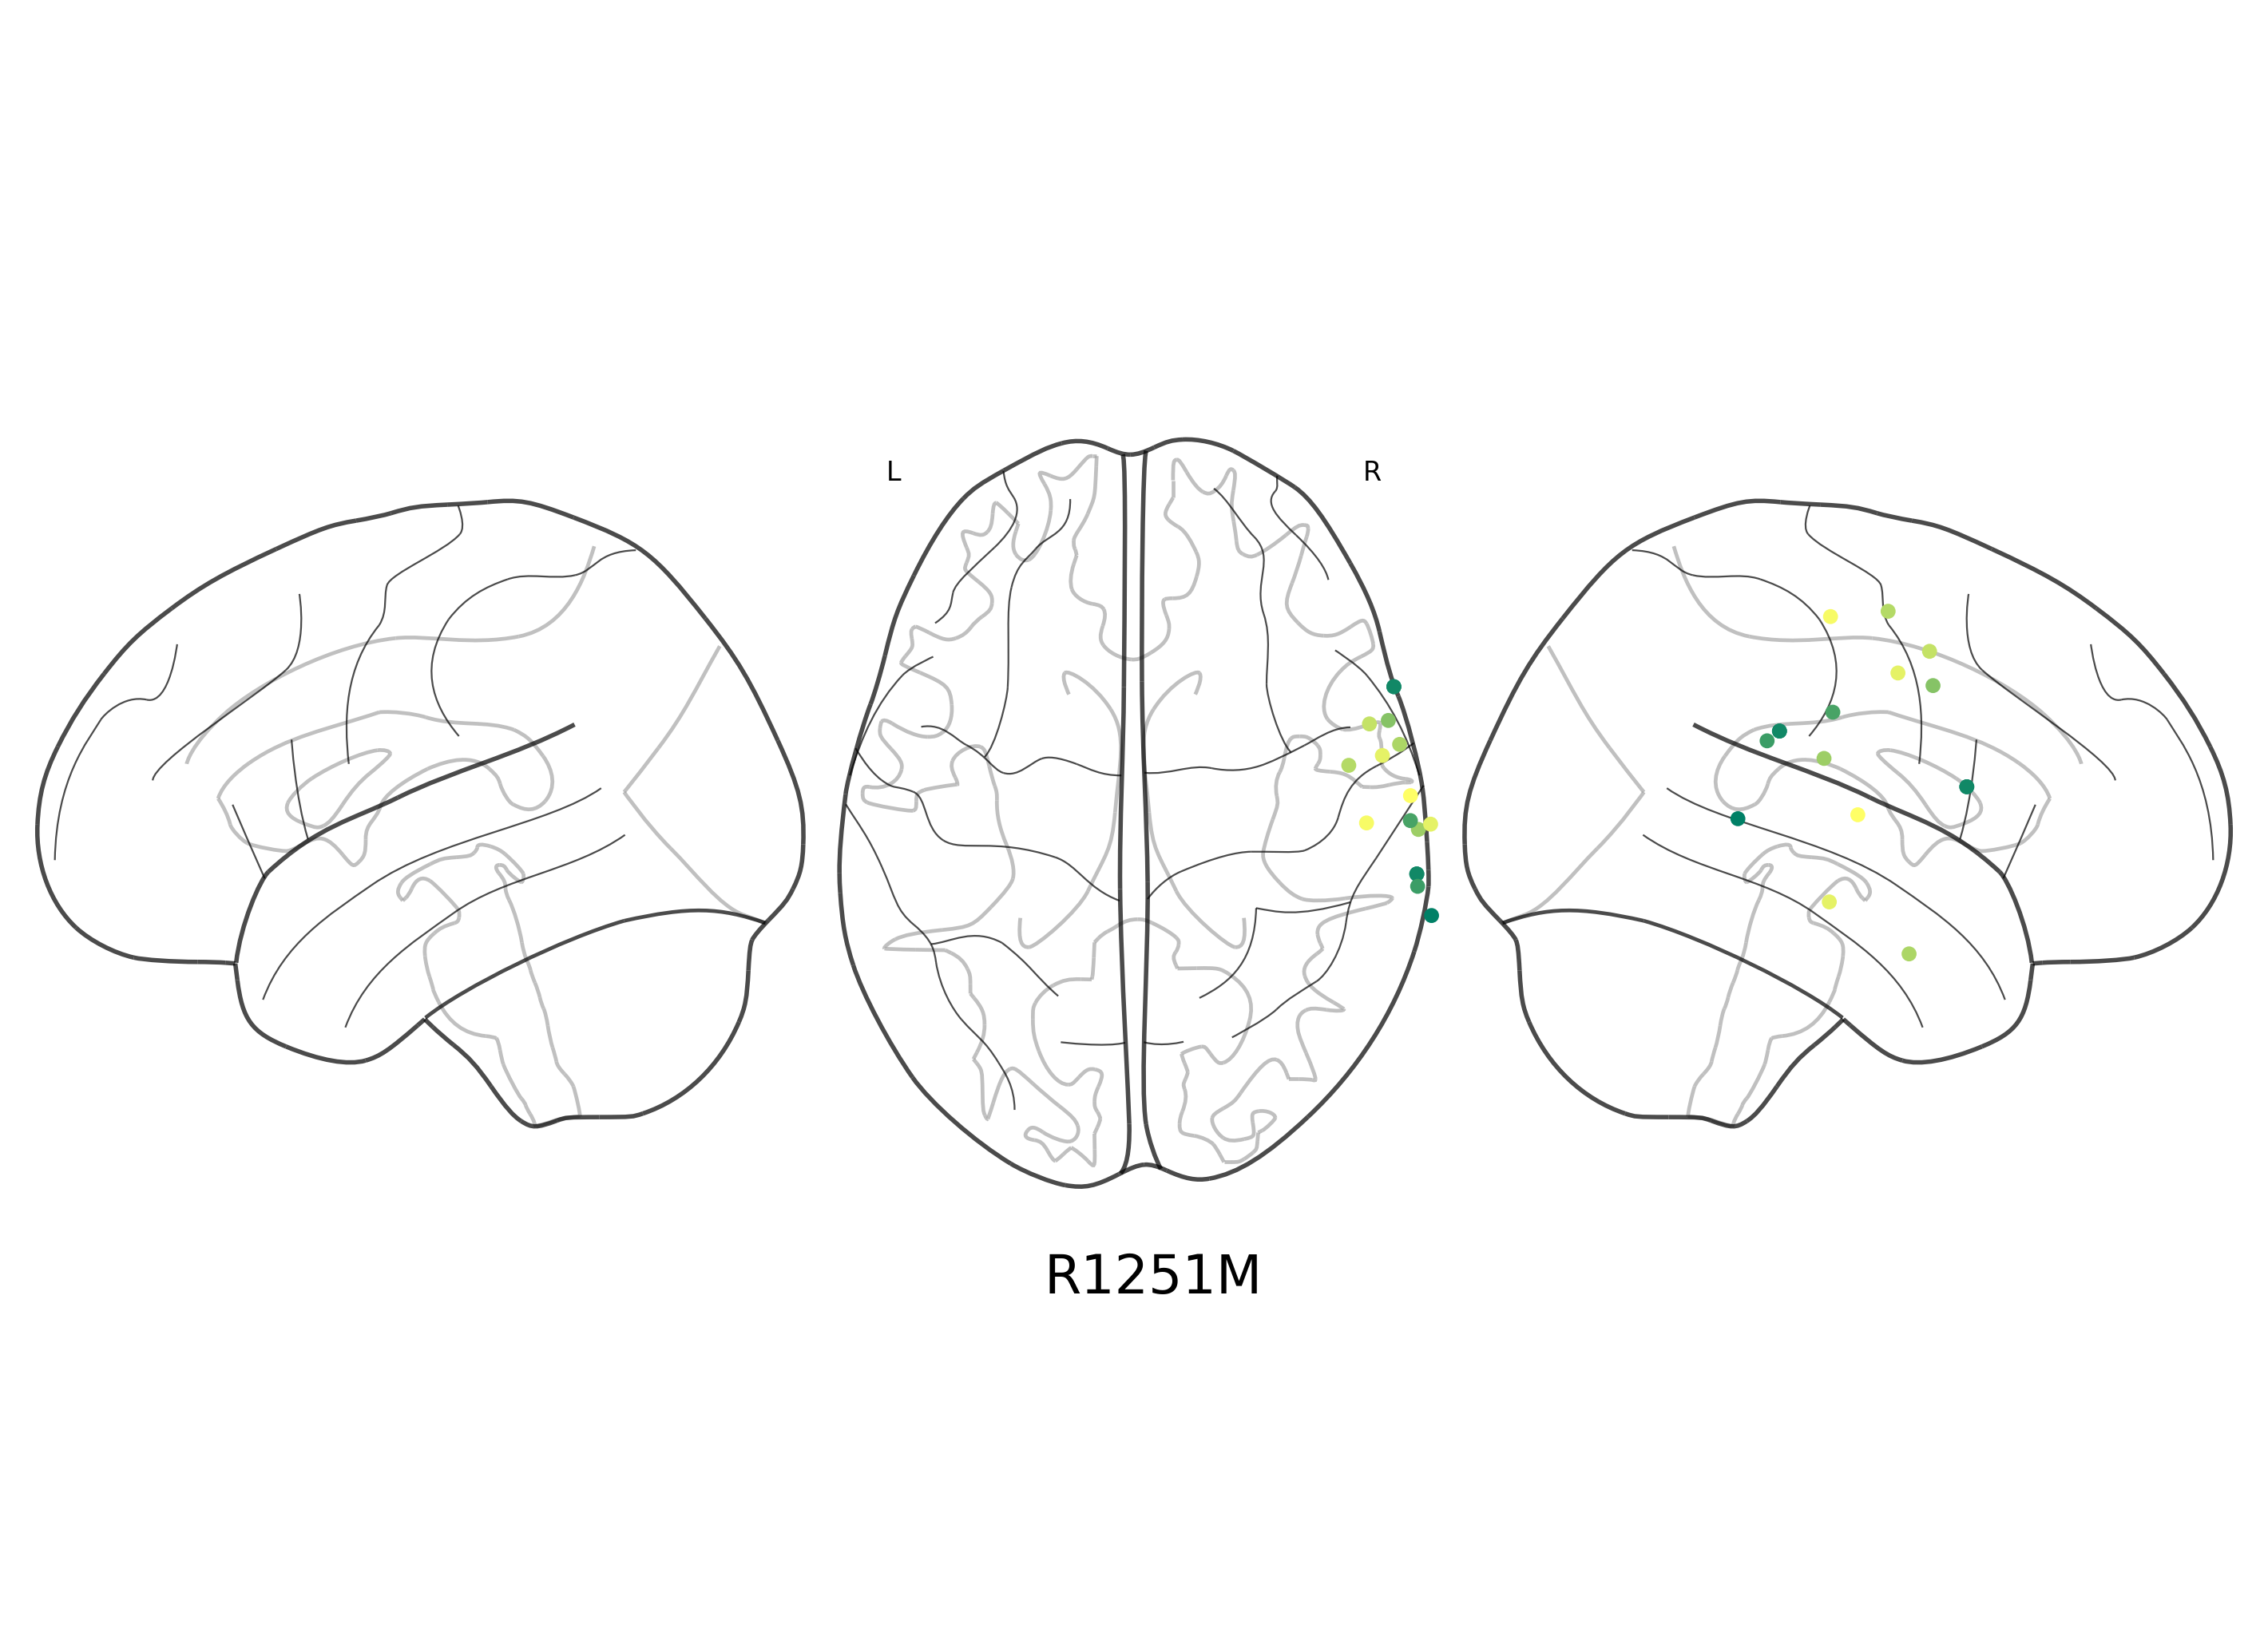

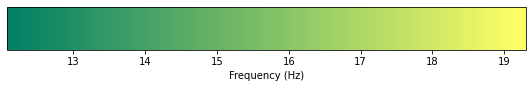

In [26]:
####freq
##d5 bug
##### fre >12 Hz
#Results_Dir = '/PythonBootcamp/frequency_plot'
Results_Dir = '/home1/xinyi.lu/PythonBootcamp/frequency_plot_high/'
freqs = np.geomspace(3, 40, num=200)
xyz=[]
n=[]
m=[]
high_freq=[]
#Results_Dir = '/home1/anup.das/Results/Brain_Plots_Frequency_Grids_Strips/Retrieval/'
for i_subj in range(20,21,1):
    xyz=[]
    n=[]
    m=[]
    b=[]
    high_freq=[]
    subject = subjs['subject'].iloc[i_subj]
    
    montage = subjs['montage'].iloc[i_subj]
    events = RAM_helpers_New.load_subj_events('RAM_TH1', subject, montage, as_df=True, remove_no_eeg=True)
    events_REC = events[events['type'] == 'REC']
    events_REC = events_REC.reset_index(drop=True)
    del events
    events = events_REC
    print(subject)

    monopol_chans = RAM_helpers_New.load_elec_info(subject, montage, bipolar=False)
#Electroencephalography (EEG) power represents amount of activity in certain frequency bands of the signal while coherence between different electrodes reflects the degree to which connections are present across brain regions
    freqs = np.geomspace(3, 40, num=200)
    Freqs_Electrodes_Peak_All = np.empty((0,2))
    fig = plt.figure(figsize=(14,10), dpi= 200)
    

    # if np.squeeze(np.shape(np.nonzero(Freqs_Peak_All))).size > 0: single
    
    #Viridis = plt.get_cmap('viridis') 
    high_freq = []
    ColorMap = plt.get_cmap('summer') 

    for i_Electrode in range(0,np.shape(d20)[1],1):

        x = sm.tools.tools.add_constant(np.log10(np.transpose(freqs)))
        model_res = sm.RLM(np.asarray(d20[:,i_Electrode]), x).fit()
        resid_zscored = stats.zscore(model_res.resid)

        Index_Peaks = sp.signal.find_peaks(resid_zscored)[0]
        Values_Peaks = resid_zscored[Index_Peaks]
        Index_Peaks_Th = np.argwhere(Values_Peaks > 1)
#Find the indices of array elements that are non-zero, grouped by element.
        if Index_Peaks_Th.size > 0:

            if (np.squeeze(Index_Peaks_Th)).size == 1:

                Index_Peaks_All_Th = np.array([Index_Peaks[np.squeeze(Index_Peaks_Th)]])
                Values_Peaks_All_Th = np.array([Values_Peaks[np.squeeze(Index_Peaks_Th)]])
                Freqs_Peak = np.squeeze(freqs[Index_Peaks_All_Th])
            #print(np.squeeze(freqs[Index_Peaks_All_Th]))
                Freqs_Electrodes_Peak_All = np.append(Freqs_Electrodes_Peak_All, np.array([[int(i_Electrode), Freqs_Peak]]), axis=0)

            else:

                Index_Peaks_All_Th = np.array([Index_Peaks[np.squeeze(Index_Peaks_Th)]])
                Values_Peaks_All_Th = np.array([Values_Peaks[np.squeeze(Index_Peaks_Th)]])
                Index_Peaks_All_Th = np.squeeze(Index_Peaks_All_Th)
                for i_freq_peak in range(0,Index_Peaks_All_Th.size,1):
                    Freqs_Peak = freqs[Index_Peaks_All_Th[i_freq_peak]] 
                    Freqs_Electrodes_Peak_All = np.append(Freqs_Electrodes_Peak_All, np.array([[int(i_Electrode), Freqs_Peak]]), axis=0)
        #print(Freqs_Electrodes_Peak_All)
    
    #print(np.squeeze(np.shape(np.nonzero(Freqs_Electrodes_Peak_All))).size)

    #values = Freqs_Electrodes_Peak_All[np.nonzero(Freqs_Electrodes_Peak_All)]
    #print(values)
    for i in range (0,len(Freqs_Electrodes_Peak_All)):
        if Freqs_Electrodes_Peak_All[i] [1] >12:
            high_freq.append(Freqs_Electrodes_Peak_All[i])
    f=np.squeeze(high_freq)
    print(f)
    if f.size == 2:
        n.append(f[0])
        b.append(f[1])
        new = monopol_chans.iloc[int(n[0])]
        #print(new)
        if 'mni.x' in new:
             MNI_Coords = new[['mni.x', 'mni.y', 'mni.z']]
        elif 'tal.x' in monopol_chans:
            MNI_Coords = new[['tal.x', 'tal.y', 'tal.z']]
        xyz_All = np.asarray(MNI_Coords)
        q=np.array(xyz_All)
        m=q.reshape(1,-1)
        b=np.asarray(b)
        m=np.array(m)
        #print(b.size)
        print(m)
        #print(m[1])
        print("xxx")
        #print(len(new))
        ni_plot.plot_connectome(np.eye(m.shape[0]), m,
                        node_kwargs={'alpha': 1, 'edgecolors': None, 'cmap': ColorMap},
                        node_size=20,node_color = b, display_mode='lzr', figure=fig)
        
    else:
        n=f[:,0]
        b=f[:,1]
        
        #print(monopol_chans)
        print("xx")
        for j in range (0,len(n)): 
            new = monopol_chans.iloc[int(n[j])]
            values = Freqs_Electrodes_Peak_All[np.nonzero(Freqs_Electrodes_Peak_All)]
            if 'mni.x' in new:
                MNI_Coords = new[['mni.x', 'mni.y', 'mni.z']]
            elif 'tal.x' in monopol_chans:
                MNI_Coords = new[['tal.x', 'tal.y', 'tal.z']]
    
            xyz_All = np.asarray(MNI_Coords)
        
            xyz.append(xyz_All)
        #plt.figtext(0.46, 0.2, subject, fontsize = 24)
        #plt.savefig('Brain.png', dpi=300, bbox_inches='tight')
            
            m=np.array(xyz)
    

        ni_plot.plot_connectome(np.eye(m.shape[0]), m,
                        node_kwargs={'alpha': 1, 'edgecolors': None, 'cmap':ColorMap},
                        node_size=len(new),node_color =b, display_mode='lzr', figure=fig)
        
                 
    plt.figtext(0.46, 0.2, subject, fontsize = 24)
    plt.savefig('Brain.png', dpi=300, bbox_inches='tight')
    #a = np.array([[np.min(values), np.max(values)]])
    # (del)a = np.array([[np.min(Freqs_Peak_All), np.max(Freqs_Peak_All)]])
    pyl.figure(figsize=(9, 1.5))
    #plt.savefig('Brain.png', dpi=300, bbox_inches='tight') 
    #img = pyl.imshow(a, cmap="spring")
    #cax = pyl.axes([0.1, 0.2, 0.8, 0.4])
    #pyl.colorbar(orientation="horizontal", cax=cax, label = 'Frequency (Hz)')
    #a = np.array([[12, 30]])
    a = np.array([[np.min(f[:,1]), np.max(Freqs_Electrodes_Peak_All[:,1])]])
    print(a)
    #plt.savefig('Colorbar.png', dpi=300, bbox_inches='tight')
    img = pyl.imshow(a, cmap="summer")
    pyl.gca().set_visible(False)
    cax = pyl.axes([0.1, 0.2, 0.8, 0.4])
    pyl.colorbar(orientation="horizontal", cax=cax, label = 'Frequency (Hz)')
    #plt.savefig('subject' +  , dpi=300, bbox_inches='tight')
    plt.savefig('Colorbar.png', dpi=300, bbox_inches='tight')
    im1 = Image.open('Brain.png')
    im2 = Image.open('Colorbar.png')
    Combined = im1.copy()
    Combined.paste(im2, (950, 350))
    #Combined.save(Results_Dir + 'frequency_plot' + str(i_subj) + '.png', quality=300)
    #Combined.save(Results_Dir  , quality=300)
    Combined.save(Results_Dir+subject+".png"  , quality=300)
    

R1251M
[[ 0.          9.55508509]
 [ 1.          9.309549  ]
 [ 2.          9.43151806]
 [ 4.         10.33123665]
 [ 5.         10.19763237]
 [ 6.         10.74264403]
 [ 8.          9.80709712]
 [ 9.          9.43151806]
 [10.         11.61526001]
 [11.         10.6037194 ]
 [12.          8.72295937]
 [12.          9.07032242]
 [13.         10.06575587]
 [14.          9.55508509]
 [15.          9.80709712]
 [16.          9.9355848 ]
 [17.         10.46659135]
 [17.         11.17043436]
 [18.          5.31926256]
 [19.         10.6037194 ]
 [20.         10.06575587]
 [21.          9.18915725]
 [22.         10.88338879]
 [23.          9.9355848 ]
 [24.         10.46659135]
 [24.         11.17043436]
 [25.         11.3167838 ]
 [26.          4.15379651]
 [28.          9.68027104]
 [29.          9.9355848 ]
 [30.         10.19763237]
 [31.         10.33123665]
 [33.          9.80709712]
 [34.          9.07032242]
 [35.          9.55508509]
 [36.         10.74264403]
 [37.         10.0657

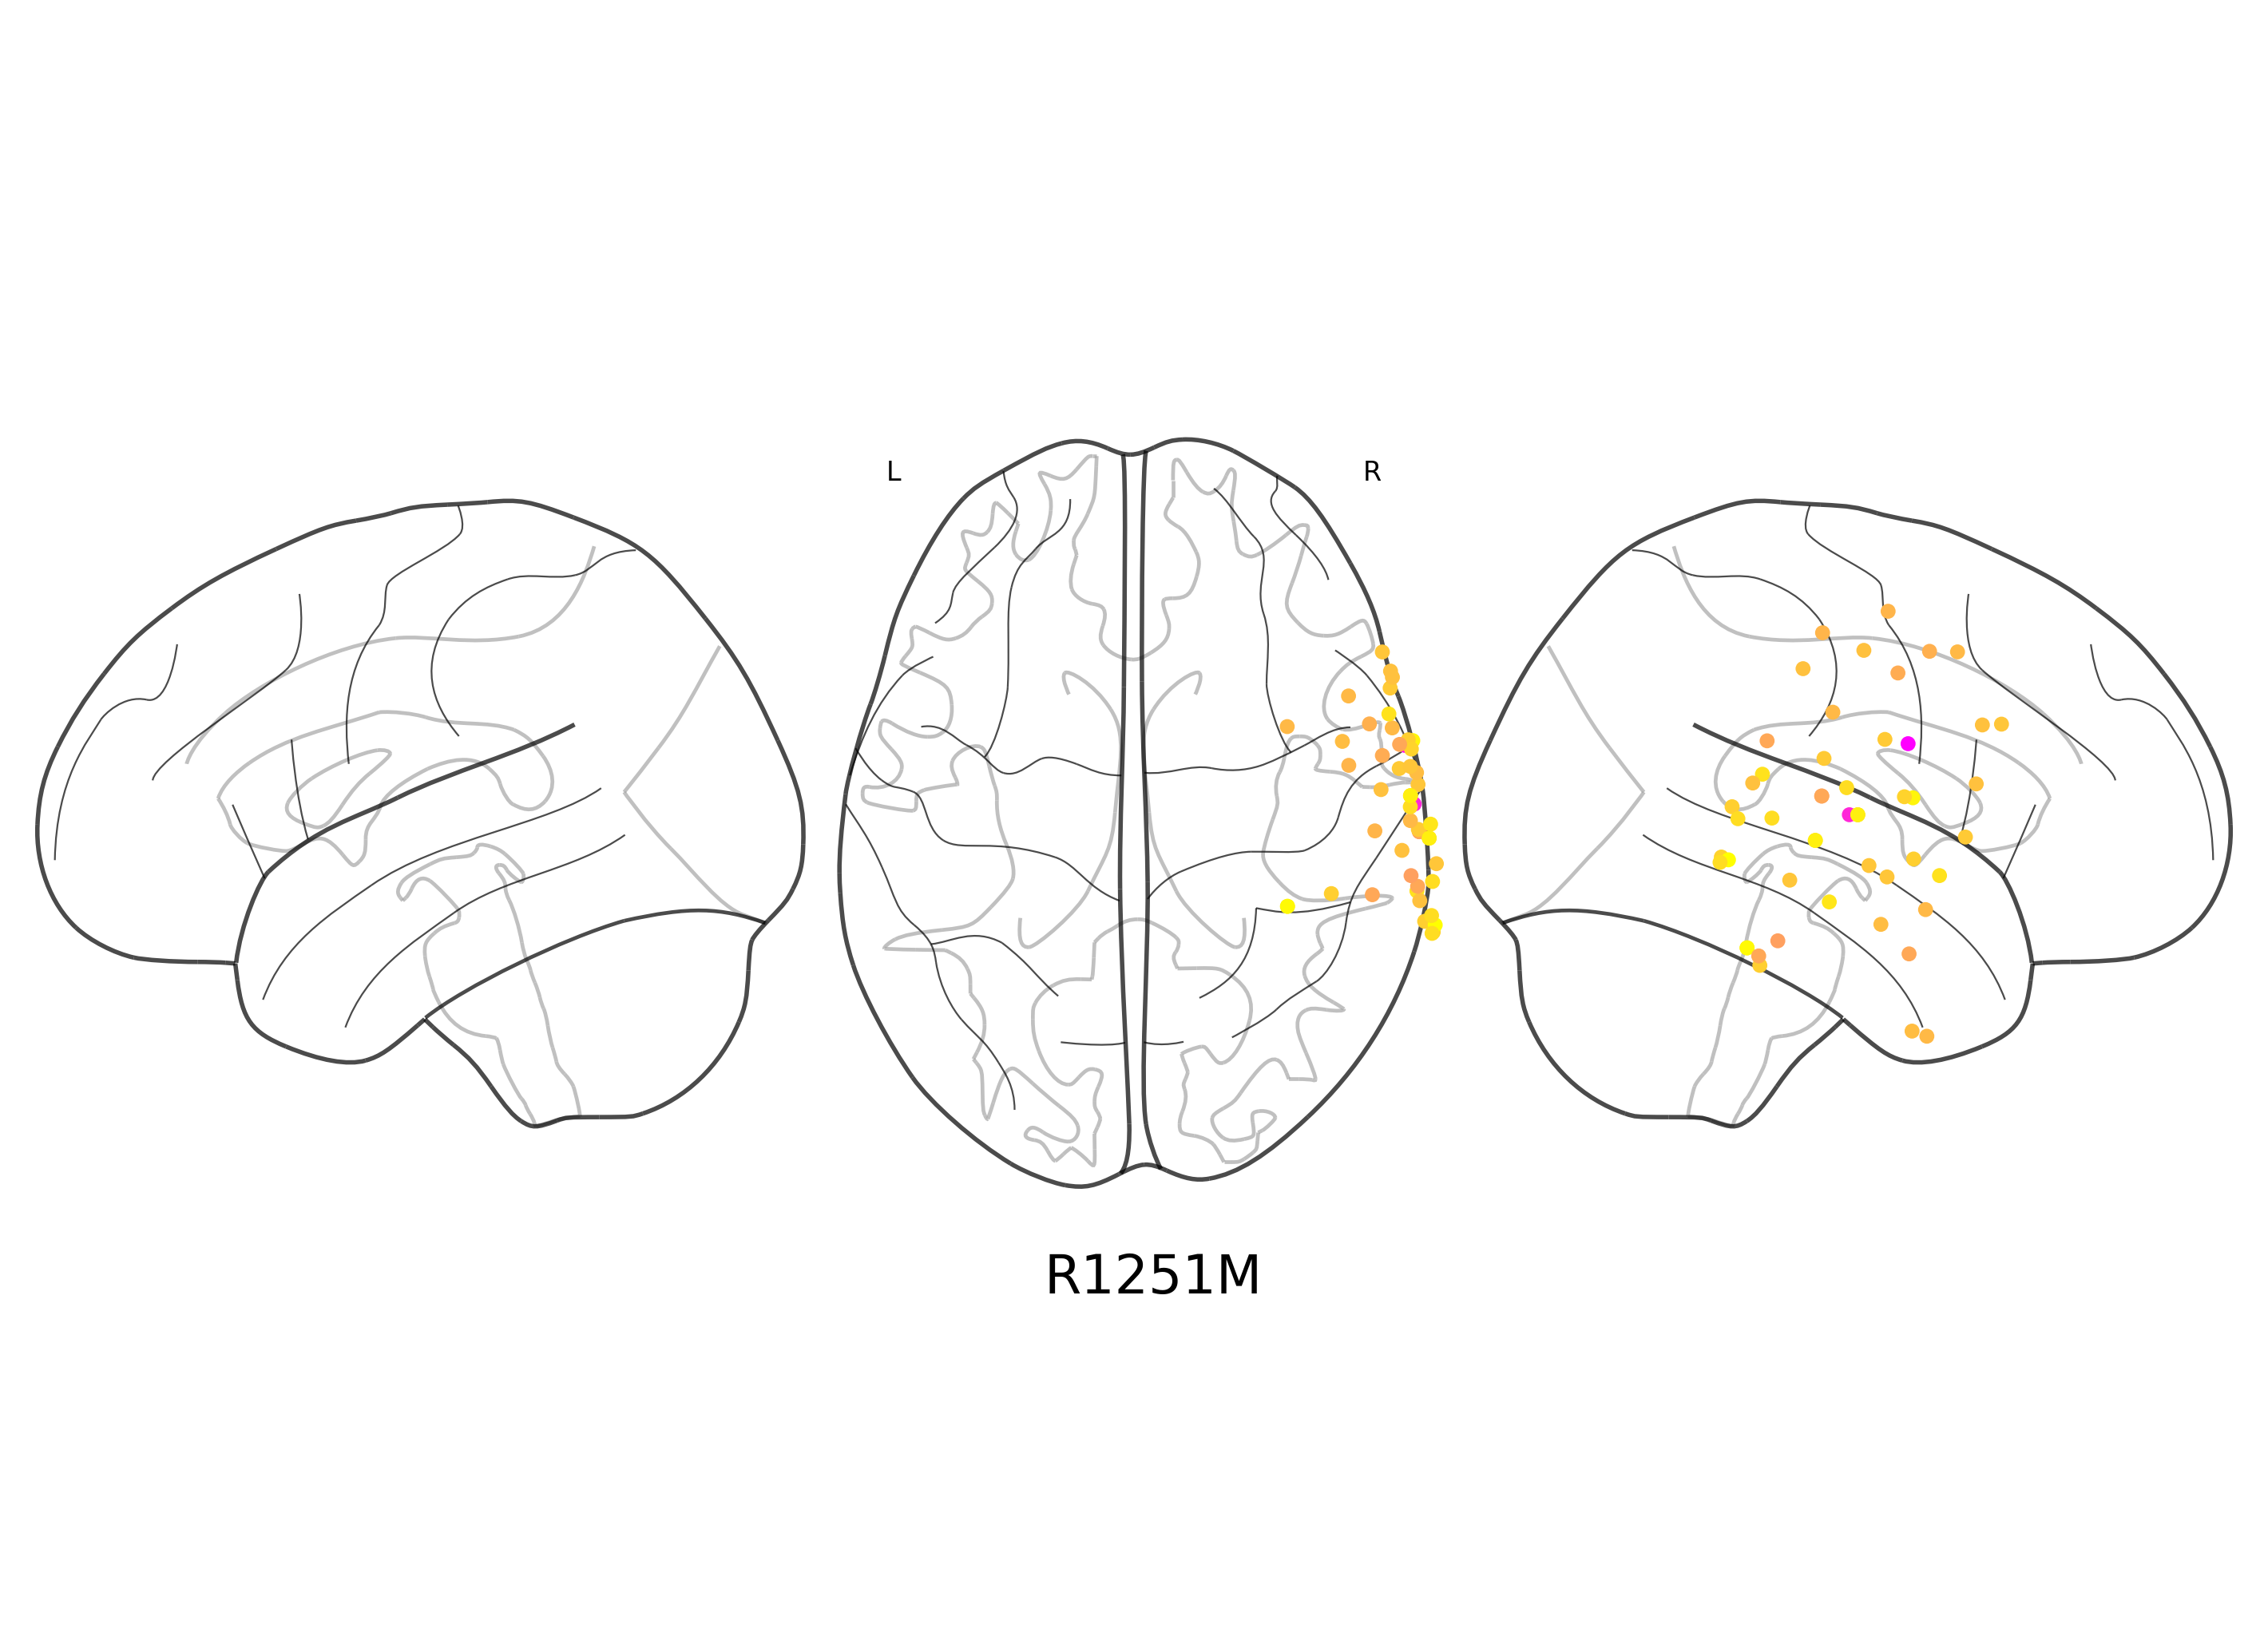

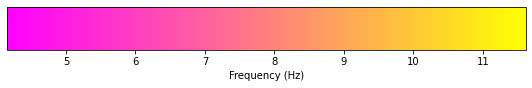

In [39]:
####freq
##d5 bug
##### fre >12 Hz
#Results_Dir = '/PythonBootcamp/frequency_plot'
Results_Dir = '/home1/xinyi.lu/PythonBootcamp/frequency_plot_low/'
freqs = np.geomspace(3,40,num=200)
xyz=[]
n=[]
m=[]
high_freq=[]
#Results_Dir = '/home1/anup.das/Results/Brain_Plots_Frequency_Grids_Strips/Retrieval/'
for i_subj in range(20,21,1):
    xyz=[]
    n=[]
    m=[]
    b=[]
    high_freq=[]
    subject = subjs['subject'].iloc[i_subj]
    
    montage = subjs['montage'].iloc[i_subj]
    events = RAM_helpers_New.load_subj_events('RAM_TH1', subject, montage, as_df=True, remove_no_eeg=True)
    events_REC = events[events['type'] == 'REC']
    events_REC = events_REC.reset_index(drop=True)
    del events
    events = events_REC
    print(subject)

    monopol_chans = RAM_helpers_New.load_elec_info(subject, montage, bipolar=False)
#Electroencephalography (EEG) power represents amount of activity in certain frequency bands of the signal while coherence between different electrodes reflects the degree to which connections are present across brain regions
    freqs = np.geomspace(3, 40, num=200)
    Freqs_Electrodes_Peak_All = np.empty((0,2))
    fig = plt.figure(figsize=(14,10), dpi= 200)
    

    # if np.squeeze(np.shape(np.nonzero(Freqs_Peak_All))).size > 0: single
    
    #Viridis = plt.get_cmap('viridis') 
    high_freq = []
    ColorMap = plt.get_cmap('spring') 

    for i_Electrode in range(0,np.shape(d20)[1],1):

        x = sm.tools.tools.add_constant(np.log10(np.transpose(freqs)))
        model_res = sm.RLM(np.asarray(d20[:,i_Electrode]), x).fit()
        resid_zscored = stats.zscore(model_res.resid)

        Index_Peaks = sp.signal.find_peaks(resid_zscored)[0]
        Values_Peaks = resid_zscored[Index_Peaks]
        Index_Peaks_Th = np.argwhere(Values_Peaks > 1)
#Find the indices of array elements that are non-zero, grouped by element.
        if Index_Peaks_Th.size > 0:

            if (np.squeeze(Index_Peaks_Th)).size == 1:

                Index_Peaks_All_Th = np.array([Index_Peaks[np.squeeze(Index_Peaks_Th)]])
                Values_Peaks_All_Th = np.array([Values_Peaks[np.squeeze(Index_Peaks_Th)]])
                Freqs_Peak = np.squeeze(freqs[Index_Peaks_All_Th])
            #print(np.squeeze(freqs[Index_Peaks_All_Th]))
                Freqs_Electrodes_Peak_All = np.append(Freqs_Electrodes_Peak_All, np.array([[int(i_Electrode), Freqs_Peak]]), axis=0)

            else:

                Index_Peaks_All_Th = np.array([Index_Peaks[np.squeeze(Index_Peaks_Th)]])
                Values_Peaks_All_Th = np.array([Values_Peaks[np.squeeze(Index_Peaks_Th)]])
                Index_Peaks_All_Th = np.squeeze(Index_Peaks_All_Th)
                for i_freq_peak in range(0,Index_Peaks_All_Th.size,1):
                    Freqs_Peak = freqs[Index_Peaks_All_Th[i_freq_peak]] 
                    Freqs_Electrodes_Peak_All = np.append(Freqs_Electrodes_Peak_All, np.array([[int(i_Electrode), Freqs_Peak]]), axis=0)
        #print(Freqs_Electrodes_Peak_All)
    
    #print(np.squeeze(np.shape(np.nonzero(Freqs_Electrodes_Peak_All))).size)

    #values = Freqs_Electrodes_Peak_All[np.nonzero(Freqs_Electrodes_Peak_All)]
    #print(values)
    for i in range (0,len(Freqs_Electrodes_Peak_All)):
        if Freqs_Electrodes_Peak_All[i] [1] <12:
            high_freq.append(Freqs_Electrodes_Peak_All[i])
    f=np.squeeze(high_freq)
    print(f)
    if f.size == 2:
        n.append(f[0])
        b.append(f[1])
        new = monopol_chans.iloc[int(n[0])]
        #print(new)
        if 'mni.x' in new:
             MNI_Coords = new[['mni.x', 'mni.y', 'mni.z']]
        elif 'tal.x' in monopol_chans:
            MNI_Coords = new[['tal.x', 'tal.y', 'tal.z']]
        xyz_All = np.asarray(MNI_Coords)
        q=np.array(xyz_All)
        m=q.reshape(1,-1)
        b=np.asarray(b)
        m=np.array(m)
        #print(b.size)
        print(m)
        #print(m[1])
        print("xxx")
        #print(len(new))
        ni_plot.plot_connectome(np.eye(m.shape[0]), m,
                        node_kwargs={'alpha': 1, 'edgecolors': None, 'cmap': ColorMap},
                        node_size=20,node_color = b, display_mode='lzr', figure=fig)
        
    else:
        n=f[:,0]
        b=f[:,1]
        
        #print(monopol_chans)
        print("xx")
        for j in range (0,len(n)): 
            new = monopol_chans.iloc[int(n[j])]
            values = Freqs_Electrodes_Peak_All[np.nonzero(Freqs_Electrodes_Peak_All)]
            if 'mni.x' in new:
                MNI_Coords = new[['mni.x', 'mni.y', 'mni.z']]
            elif 'tal.x' in monopol_chans:
                MNI_Coords = new[['tal.x', 'tal.y', 'tal.z']]
    
            xyz_All = np.asarray(MNI_Coords)
        
            xyz.append(xyz_All)
        #plt.figtext(0.46, 0.2, subject, fontsize = 24)
        #plt.savefig('Brain.png', dpi=300, bbox_inches='tight')
            
            m=np.array(xyz)
    

        ni_plot.plot_connectome(np.eye(m.shape[0]), m,
                        node_kwargs={'alpha': 1, 'edgecolors': None, 'cmap':ColorMap},
                        node_size=len(new),node_color =b, display_mode='lzr', figure=fig)
        
         
    plt.figtext(0.46, 0.2, subject, fontsize = 24)
    plt.savefig('Brain.png', dpi=300, bbox_inches='tight')
    #a = np.array([[np.min(values), np.max(values)]])
    # (del)a = np.array([[np.min(Freqs_Peak_All), np.max(Freqs_Peak_All)]])
    pyl.figure(figsize=(9, 1.5))
    #plt.savefig('Brain.png', dpi=300, bbox_inches='tight') 
    #img = pyl.imshow(a, cmap="spring")
    #cax = pyl.axes([0.1, 0.2, 0.8, 0.4])
    #pyl.colorbar(orientation="horizontal", cax=cax, label = 'Frequency (Hz)')
    #a = np.array([[0, 200]])
    #a = np.array([[np.min(Freqs_Electrodes_Peak_All[:,1]), np.max(Freqs_Electrodes_Peak_All[:,1])]])
    a = np.array([[np.min(Freqs_Electrodes_Peak_All[:,1]), np.max(f[:,1])]])
    print(a)
    
    #plt.savefig('Colorbar.png', dpi=300, bbox_inches='tight')
    img = pyl.imshow(a,cmap='spring')
    pyl.gca().set_visible(False)
    cax = pyl.axes([0.1, 0.2, 0.8, 0.4])
    pyl.colorbar(orientation="horizontal", cax=cax, label = 'Frequency (Hz)')
    #plt.savefig('subject' +  , dpi=300, bbox_inches='tight')
    plt.savefig('Colorbar.png', dpi=300, bbox_inches='tight')
    im1 = Image.open('Brain.png')
    im2 = Image.open('Colorbar.png')
    Combined = im1.copy()
    Combined.paste(im2, (950, 350))
    #Combined.save(Results_Dir + 'frequency_plot' + str(i_subj) + '.png', quality=300)
    #Combined.save(Results_Dir  , quality=300)
    Combined.save(Results_Dir+subject+".png"  , quality=300)
    